# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

# Model Training Workflow

- **1.Data Preparation**
- **2.Visualization**
- **3.VGG Initialization**
- **4.Defining Required Functions**
- **5.Trying Out Variations of VGG**
- **6.ResNet Initialization**
- **7.Trying Out Variations of ResNet**


## Step 1: Data preparation

1. Load CNN dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from torchvision import datasets, transforms
from torch.utils.data import random_split,DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [3]:
dataset = datasets.ImageFolder(root="cnn_dataset", transform=transforms.ToTensor())

dataset2 = datasets.ImageFolder(root="cnn_dataset", transform=transform2)

batch_size = 64 

In [38]:
import random

random.seed(0)  
np.random.seed(0)  
torch.manual_seed(0) 
torch.cuda.manual_seed(0)  
torch.cuda.manual_seed_all(0)  
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False  

Split the dataset into training, testing, and validation sets.

In [4]:
total= len(dataset)
train = int(0.7 * total)  
val = int(0.15 * total)  
test = total - train - val  


train_dataset, val_dataset, test_dataset = random_split(dataset, [train, val, test])
train_dataset_aug, val_dataset_aug, test_dataset_aug = random_split(dataset2, [train, val, test])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader32 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader32 = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader32 = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader128 = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader128 = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader128 = DataLoader(test_dataset, batch_size=128, shuffle=False)

#augumented data with different batch size

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

train_loader32_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
val_loader32_aug = DataLoader(val_dataset_aug, batch_size=32, shuffle=False)
test_loader32_aug = DataLoader(test_dataset_aug, batch_size=32, shuffle=False)

train_loader128_aug = DataLoader(train_dataset_aug, batch_size=128, shuffle=True)
val_loader128_aug = DataLoader(val_dataset_aug, batch_size=128, shuffle=False)
test_loader128_aug = DataLoader(test_dataset_aug, batch_size=128, shuffle=False)


print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 21000, Validation size: 4500, Test size: 4500


Analyze the dataset.

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 30000
    Root location: cnn_dataset
    StandardTransform
Transform: ToTensor()

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows. 

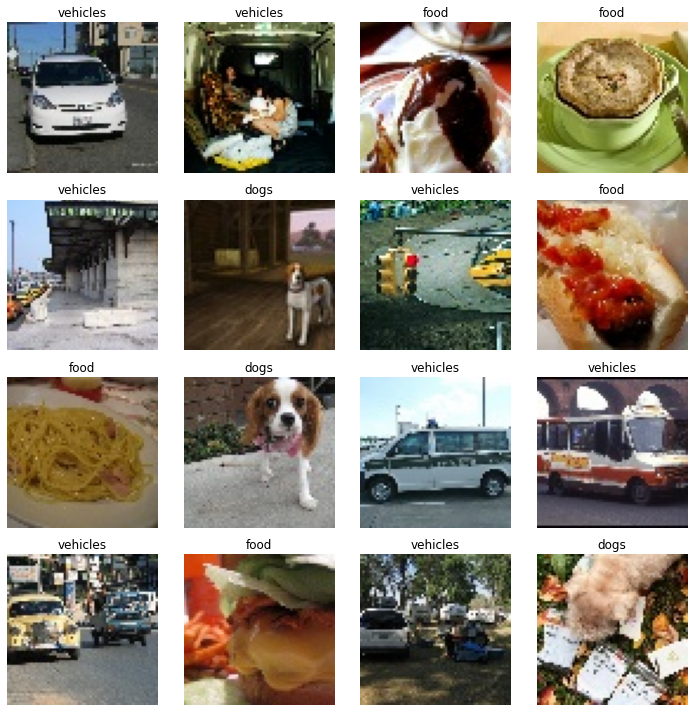

In [6]:
def imshow_batch(images, labels, class_names, rows=4, cols=4):

  
    np_images = images.numpy()
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        img = np.transpose(np_images[i], (1, 2, 0))  
        axes[i].imshow(np.clip(img, 0, 1))  
        axes[i].set_title(class_names[labels[i].item()]) 
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow_batch(images, labels, dataset.classes)

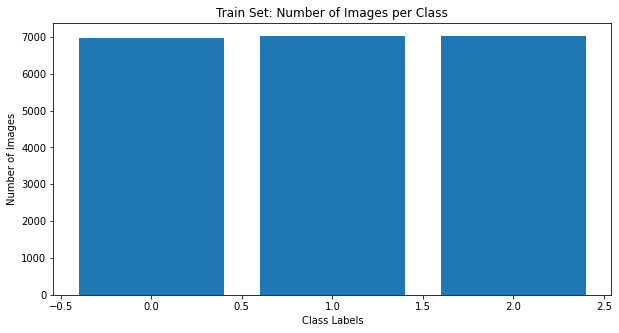

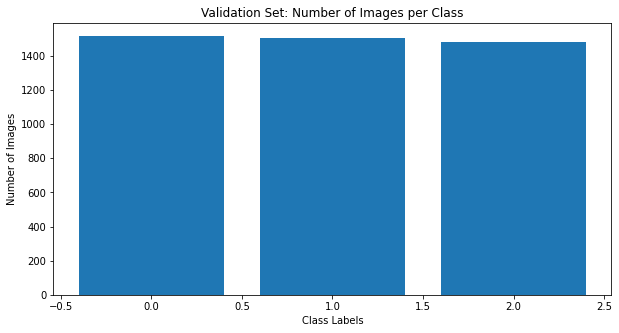

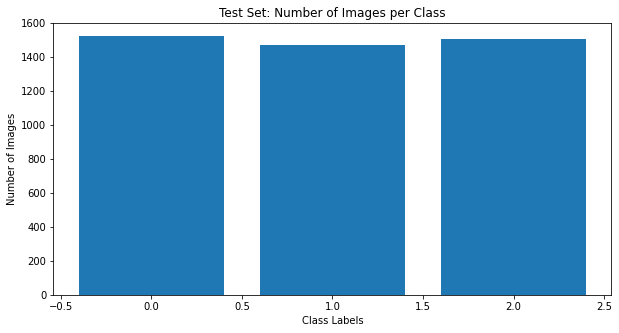

In [6]:
def plot_class_distribution(loader, title):
    
    labels = []
    

    for _, targets in loader:
        labels.extend(targets.numpy()) 
    

    class_counts = Counter(labels)
    
   
    class_labels = list(class_counts.keys())
    counts = list(class_counts.values())
  

    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, counts)
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.show()

    
plot_class_distribution(train_loader, "Train Set: Number of Images per Class")
plot_class_distribution(val_loader, "Validation Set: Number of Images per Class")
plot_class_distribution(test_loader, "Test Set: Number of Images per Class")


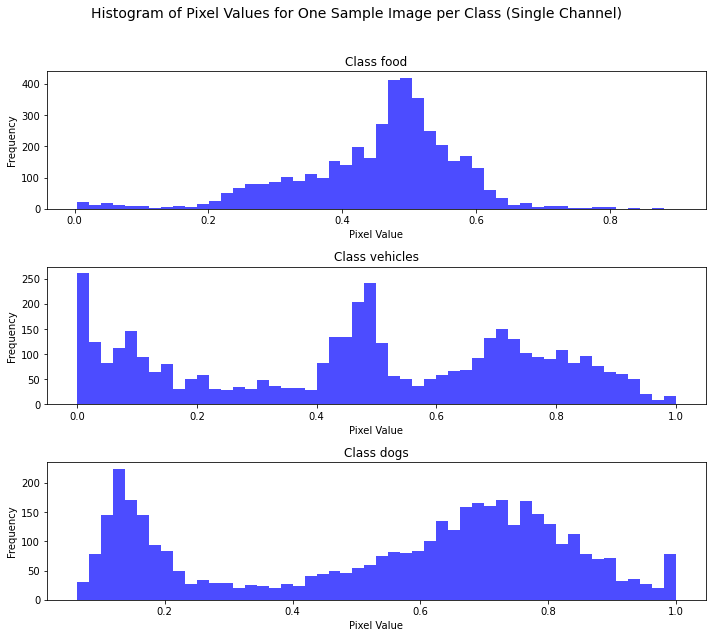

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_histograms_one_per_class(loader, original_dataset, num_bins=50):
    class_samples = {}

  
    for images, labels in loader:
        for img, label in zip(images, labels):
            label = label.item()  
            if label not in class_samples:
                
                img_np = img.numpy()
                if img_np.shape[0] == 3:  
                    img_np = img_np[0]
                
                class_samples[label] = img_np.flatten() 
            
            
            if len(class_samples) >= len(original_dataset.classes):
                break
        if len(class_samples) >= len(original_dataset.classes):
            break
    
    
    fig, axes = plt.subplots(len(class_samples), 1, figsize=(10, 3 * len(class_samples)))
    fig.suptitle("Histogram of Pixel Values for One Sample Image per Class (Single Channel)", fontsize=14)
    
    if len(class_samples) == 1:
        axes = [axes]  

    for ax, (label, sample) in zip(axes, class_samples.items()):
        ax.hist(sample, bins=num_bins, color='blue', alpha=0.7)
        ax.set_title(f"Class {original_dataset.classes[label]}")
        ax.set_xlabel("Pixel Value")
        ax.set_ylabel("Frequency")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


original_dataset = train_loader.dataset.dataset


plot_pixel_histograms_one_per_class(train_loader, original_dataset)


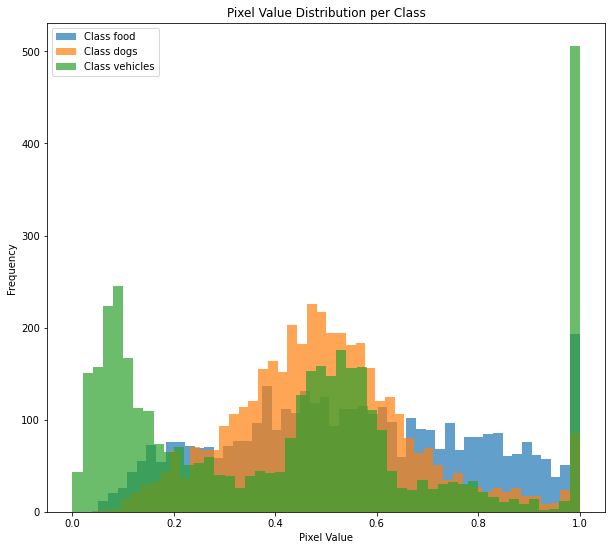

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_histograms(loader, dataset, num_bins=50):
    class_samples = {}

    for images, labels in loader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in class_samples:
                img_np = img.numpy()[0]  
                class_samples[label] = img_np.flatten()
            if len(class_samples) >= len(dataset.classes):
                break
        if len(class_samples) >= len(dataset.classes):
            break

    plt.figure(figsize=(10, 3 * len(class_samples)))
    for label, sample in class_samples.items():
        plt.hist(sample, bins=num_bins, alpha=0.7, label=f"Class {dataset.classes[label]}")
    
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.title("Pixel Value Distribution per Class")
    plt.legend()
    plt.show()

original_dataset = train_loader.dataset.dataset

plot_pixel_histograms(train_loader, original_dataset)


## Step 2: Implementing VGG

1. Implement the VGG-16 (Version C) architecture.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")


class VGG16C(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16C, self).__init__()
        
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=1),  
            nn.ReLU(),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=1), 
            nn.ReLU(),
        )
        
     
        self.classifier = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(8 * 8 * 512, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(dataset.classes)

model = VGG16C(num_classes=num_classes).to(device)

print(f"Using device: {device}")
print(model)


Using device: cuda
VGG16C(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1

In [10]:
#function for training
import time
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        train_acc = correct / total
        train_accs.append(train_acc)

       
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()
        log_to_tensorboard(epoch, train_loss, val_loss, train_acc, val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {(time.time() - epoch_start):.1f}s")

    return train_losses, val_losses, train_accs, val_accs

In [90]:
#function for Early stop
import time
from tqdm import tqdm

def ES_train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    best_val_loss = float('inf') 
    no_improve_count = 0  

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        train_acc = correct / total
        train_accs.append(train_acc)

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        log_to_tensorboard(epoch, train_loss, val_loss, train_acc, val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {(time.time() - epoch_start):.1f}s")

       
        if val_loss < best_val_loss:
            best_val_loss = val_loss  
            no_improve_count = 0  
        else:
            no_improve_count += 1  

        if no_improve_count >= patience:
            print("Early stopping triggered!")
            break  

    return train_losses, val_losses, train_accs, val_accs


In [11]:
#plot function
def loss_acc():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label="Train Loss")
    plt.plot(range(num_epochs), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label="Train Accuracy")
    plt.plot(range(num_epochs), val_accs, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")
    
    plt.show()

In [12]:
#tensorboard 
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter(log_dir="runs/experiment")

def log_to_tensorboard(epoch, train_loss, val_loss, train_acc, val_acc):
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)


2025-02-24 21:43:40.366656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 21:43:40.502152: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [13]:
# test function
def test_model(model, test_loader):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else 
                          "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



In [15]:
# Function to compute precision, recall, and F1 score
from sklearn.metrics import precision_recall_fscore_support


def evaluate_metrics(model, test_loader):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")




In [16]:
import torch.nn as nn
import torch.nn.init as init

#intialising he and xavier weights

def xavier_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            init.constant_(m.bias, 0)

def he_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [17]:
# Function for miscalssified image
def show_misclassified_images(model, test_loader, class_names, num_images=5):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for img, label, pred in zip(images, labels, predicted):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

  
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (img, label, pred) in enumerate(misclassified):
        img = img.permute(1, 2, 0)  
        img = (img - img.min()) / (img.max() - img.min())  
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
        axes[i].axis("off")
    plt.show()

<h3>Base Model without any initialisation

100%|██████████| 329/329 [00:15<00:00, 21.69batch/s, loss=1.3, lr=0.0001] 


Epoch [1/10], Train Loss: 1.2177, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 18.0s


100%|██████████| 329/329 [00:15<00:00, 21.51batch/s, loss=1.18, lr=0.0001]


Epoch [2/10], Train Loss: 1.2174, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.41batch/s, loss=1.05, lr=0.0001]


Epoch [3/10], Train Loss: 1.2171, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.8s


100%|██████████| 329/329 [00:15<00:00, 21.79batch/s, loss=1.43, lr=0.0001]


Epoch [4/10], Train Loss: 1.2180, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.5s


100%|██████████| 329/329 [00:14<00:00, 22.12batch/s, loss=1.43, lr=0.0001]


Epoch [5/10], Train Loss: 1.2180, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.2s


100%|██████████| 329/329 [00:15<00:00, 21.71batch/s, loss=0.676, lr=1e-5]


Epoch [6/10], Train Loss: 1.2161, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.5s


100%|██████████| 329/329 [00:14<00:00, 22.08batch/s, loss=0.926, lr=1e-5]


Epoch [7/10], Train Loss: 1.2167, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.2s


100%|██████████| 329/329 [00:15<00:00, 21.67batch/s, loss=1.18, lr=1e-5]


Epoch [8/10], Train Loss: 1.2174, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.27batch/s, loss=1.18, lr=1e-5]


Epoch [9/10], Train Loss: 1.2174, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.48batch/s, loss=1.05, lr=1e-5]


Epoch [10/10], Train Loss: 1.2171, Train Acc: 0.3340, Val Loss: 1.2137, Val Acc: 0.3367, Time: 17.6s


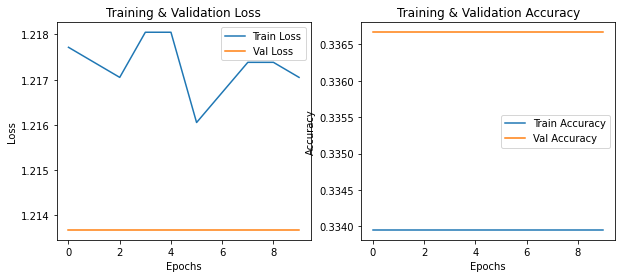

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

loss_acc()

#torch.save(model.state_dict(), "vgg16_modified.pth")
#print("Model saved successfully!")

In [48]:
test_model(model, test_loader)

Test Loss: 1.2246, Test Accuracy: 0.3271


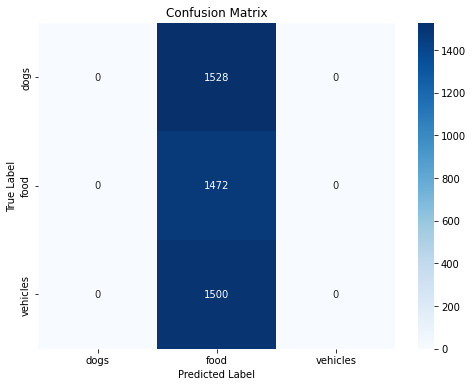

/user/amelayik/vscode/PA1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1070
Recall: 0.3271
F1 Score: 0.1613


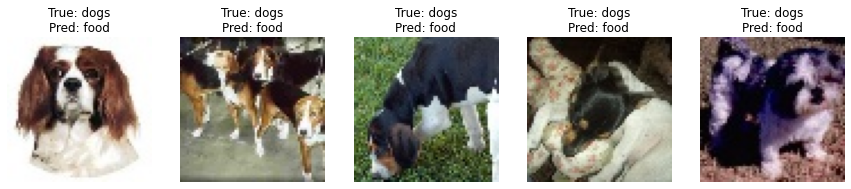

In [49]:
class_names = dataset.classes
plot_confusion_matrix(model, test_loader, class_names)
evaluate_metrics(model, test_loader)
show_misclassified_images(model, test_loader, class_names, num_images=5)

<h3> Using He Intialisation

100%|██████████| 329/329 [00:15<00:00, 21.82batch/s, loss=0.794, lr=0.0001]


Epoch [1/10], Train Loss: 0.8122, Train Acc: 0.7315, Val Loss: 0.7498, Val Acc: 0.7991, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.10batch/s, loss=0.709, lr=0.0001]


Epoch [2/10], Train Loss: 0.7501, Train Acc: 0.7977, Val Loss: 0.7215, Val Acc: 0.8280, Time: 17.9s


100%|██████████| 329/329 [00:14<00:00, 22.03batch/s, loss=0.8, lr=0.0001]  


Epoch [3/10], Train Loss: 0.7295, Train Acc: 0.8197, Val Loss: 0.7322, Val Acc: 0.8169, Time: 17.2s


100%|██████████| 329/329 [00:15<00:00, 21.64batch/s, loss=0.67, lr=0.0001] 


Epoch [4/10], Train Loss: 0.7126, Train Acc: 0.8357, Val Loss: 0.7098, Val Acc: 0.8389, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.08batch/s, loss=0.552, lr=0.0001]


Epoch [5/10], Train Loss: 0.6983, Train Acc: 0.8500, Val Loss: 0.7676, Val Acc: 0.7827, Time: 17.9s


100%|██████████| 329/329 [00:14<00:00, 22.06batch/s, loss=0.676, lr=1e-5]


Epoch [6/10], Train Loss: 0.6726, Train Acc: 0.8770, Val Loss: 0.6774, Val Acc: 0.8722, Time: 17.2s


100%|██████████| 329/329 [00:15<00:00, 21.80batch/s, loss=0.552, lr=1e-5]


Epoch [7/10], Train Loss: 0.6606, Train Acc: 0.8890, Val Loss: 0.6731, Val Acc: 0.8769, Time: 17.4s


100%|██████████| 329/329 [00:15<00:00, 21.93batch/s, loss=0.97, lr=1e-5] 


Epoch [8/10], Train Loss: 0.6589, Train Acc: 0.8919, Val Loss: 0.6658, Val Acc: 0.8827, Time: 17.3s


100%|██████████| 329/329 [00:15<00:00, 21.51batch/s, loss=0.551, lr=1e-5]


Epoch [9/10], Train Loss: 0.6548, Train Acc: 0.8952, Val Loss: 0.6658, Val Acc: 0.8849, Time: 17.6s


100%|██████████| 329/329 [00:15<00:00, 21.72batch/s, loss=0.607, lr=1e-5]


Epoch [10/10], Train Loss: 0.6510, Train Acc: 0.8996, Val Loss: 0.6639, Val Acc: 0.8871, Time: 17.4s


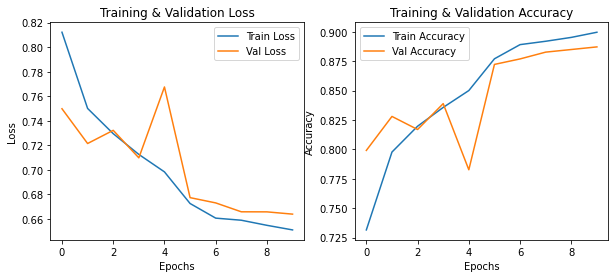

Model saved successfully!


In [42]:
he_init_model = VGG16C(num_classes=3).to(device)
he_init_model.apply(he_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(he_init_model.parameters(), lr=0.0001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_init_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

#torch.save(he_init_model.state_dict(), "vgg16_he_init_model.pth")
print("Model saved successfully!")

In [43]:
test_model(he_init_model, test_loader)

Test Loss: 0.6529, Test Accuracy: 0.8969


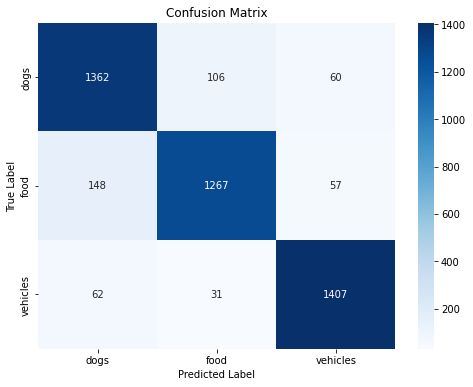

Precision: 0.8971
Recall: 0.8969
F1 Score: 0.8968


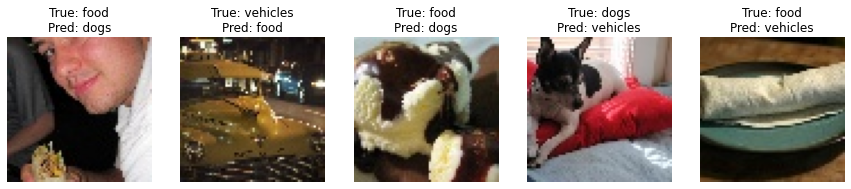

In [44]:
class_names = dataset.classes
plot_confusion_matrix(he_init_model, test_loader, class_names)
evaluate_metrics(he_init_model, test_loader)
show_misclassified_images(he_init_model, test_loader, class_names, num_images=5)

<h3>Using Xavier Initialisation

100%|██████████| 329/329 [00:14<00:00, 22.04batch/s, loss=0.78, lr=0.0001] 


Epoch [1/10], Train Loss: 0.8445, Train Acc: 0.6952, Val Loss: 0.7538, Val Acc: 0.7944, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.15batch/s, loss=0.677, lr=0.0001]


Epoch [2/10], Train Loss: 0.7764, Train Acc: 0.7708, Val Loss: 0.7345, Val Acc: 0.8142, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.12batch/s, loss=0.781, lr=0.0001]


Epoch [3/10], Train Loss: 0.7287, Train Acc: 0.8188, Val Loss: 0.7066, Val Acc: 0.8444, Time: 17.2s


100%|██████████| 329/329 [00:15<00:00, 21.51batch/s, loss=0.551, lr=0.0001]


Epoch [4/10], Train Loss: 0.7254, Train Acc: 0.8214, Val Loss: 0.6882, Val Acc: 0.8618, Time: 17.7s


100%|██████████| 329/329 [00:14<00:00, 22.02batch/s, loss=0.555, lr=0.0001]


Epoch [5/10], Train Loss: 0.6907, Train Acc: 0.8560, Val Loss: 0.6785, Val Acc: 0.8713, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.03batch/s, loss=0.551, lr=1e-5]


Epoch [6/10], Train Loss: 0.6577, Train Acc: 0.8909, Val Loss: 0.6629, Val Acc: 0.8856, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.28batch/s, loss=0.565, lr=1e-5]


Epoch [7/10], Train Loss: 0.6496, Train Acc: 0.8998, Val Loss: 0.6576, Val Acc: 0.8922, Time: 17.1s


100%|██████████| 329/329 [00:15<00:00, 21.82batch/s, loss=0.683, lr=1e-5]


Epoch [8/10], Train Loss: 0.6460, Train Acc: 0.9046, Val Loss: 0.6585, Val Acc: 0.8904, Time: 17.4s


100%|██████████| 329/329 [00:14<00:00, 22.00batch/s, loss=0.801, lr=1e-5]


Epoch [9/10], Train Loss: 0.6434, Train Acc: 0.9067, Val Loss: 0.6542, Val Acc: 0.8944, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.13batch/s, loss=0.676, lr=1e-5]


Epoch [10/10], Train Loss: 0.6400, Train Acc: 0.9103, Val Loss: 0.6514, Val Acc: 0.8978, Time: 17.1s


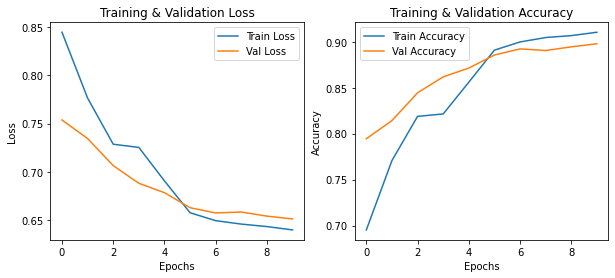

In [45]:
xe_init_model = VGG16C(num_classes=3).to(device)
xe_init_model.apply(xavier_init)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xe_init_model.parameters(), lr=0.0001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_init_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

#torch.save(xe_init_model.state_dict(), "vgg16_xe_init_model.pth")


In [46]:
test_model(xe_init_model, test_loader)

Test Loss: 0.6452, Test Accuracy: 0.9040


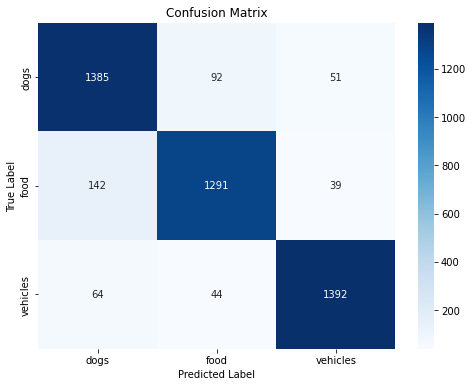

Precision: 0.9046
Recall: 0.9040
F1 Score: 0.9041


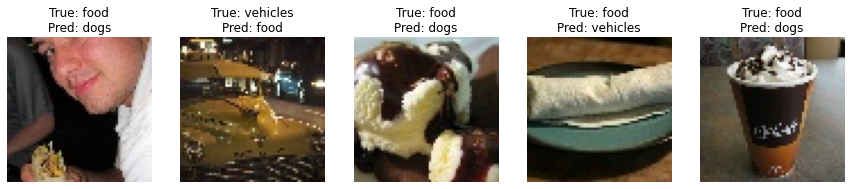

In [47]:
class_names = dataset.classes
plot_confusion_matrix(xe_init_model, test_loader, class_names)
evaluate_metrics(xe_init_model, test_loader)
show_misclassified_images(xe_init_model, test_loader, class_names, num_images=5)

<h3>Experimenting with 3 different optimizers with Xavier Intialisation

100%|██████████| 329/329 [00:14<00:00, 22.55batch/s, loss=0.551, lr=0.0001]


Epoch [1/10], Train Loss: 0.6386, Train Acc: 0.9112, Val Loss: 0.6524, Val Acc: 0.8951, Time: 17.1s


100%|██████████| 329/329 [00:14<00:00, 23.38batch/s, loss=0.563, lr=0.0001]


Epoch [2/10], Train Loss: 0.6376, Train Acc: 0.9131, Val Loss: 0.6521, Val Acc: 0.8982, Time: 16.4s


100%|██████████| 329/329 [00:13<00:00, 23.68batch/s, loss=0.748, lr=1e-5]


Epoch [3/10], Train Loss: 0.6334, Train Acc: 0.9179, Val Loss: 0.6512, Val Acc: 0.8991, Time: 16.2s


100%|██████████| 329/329 [00:13<00:00, 23.57batch/s, loss=0.676, lr=1e-5]


Epoch [4/10], Train Loss: 0.6322, Train Acc: 0.9190, Val Loss: 0.6507, Val Acc: 0.8993, Time: 16.4s


100%|██████████| 329/329 [00:14<00:00, 22.46batch/s, loss=0.696, lr=1e-6]


Epoch [5/10], Train Loss: 0.6323, Train Acc: 0.9191, Val Loss: 0.6507, Val Acc: 0.8993, Time: 17.1s


100%|██████████| 329/329 [00:15<00:00, 21.55batch/s, loss=0.677, lr=1e-6]


Epoch [6/10], Train Loss: 0.6322, Train Acc: 0.9188, Val Loss: 0.6507, Val Acc: 0.8991, Time: 17.7s


100%|██████████| 329/329 [00:14<00:00, 23.35batch/s, loss=0.676, lr=1e-7]


Epoch [7/10], Train Loss: 0.6319, Train Acc: 0.9194, Val Loss: 0.6507, Val Acc: 0.8993, Time: 16.4s


100%|██████████| 329/329 [00:13<00:00, 23.60batch/s, loss=0.553, lr=1e-7]


Epoch [8/10], Train Loss: 0.6313, Train Acc: 0.9199, Val Loss: 0.6507, Val Acc: 0.8993, Time: 16.2s


100%|██████████| 329/329 [00:14<00:00, 23.32batch/s, loss=0.565, lr=1e-8]


Epoch [9/10], Train Loss: 0.6315, Train Acc: 0.9195, Val Loss: 0.6507, Val Acc: 0.8993, Time: 16.5s


100%|██████████| 329/329 [00:14<00:00, 23.31batch/s, loss=0.551, lr=1e-8]


Epoch [10/10], Train Loss: 0.6314, Train Acc: 0.9194, Val Loss: 0.6507, Val Acc: 0.8993, Time: 16.7s


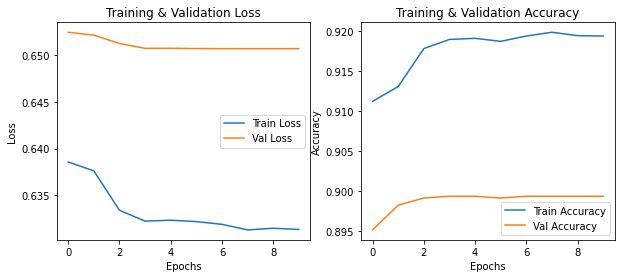

In [53]:
xe_sgd = VGG16C(num_classes=3).to(device)
xe_sgd.load_state_dict(torch.load("vgg16_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd.state_dict(), "vgg16_xe_sgd_model.pth")

In [54]:
test_model(xe_sgd, test_loader)

Test Loss: 0.6442, Test Accuracy: 0.9058


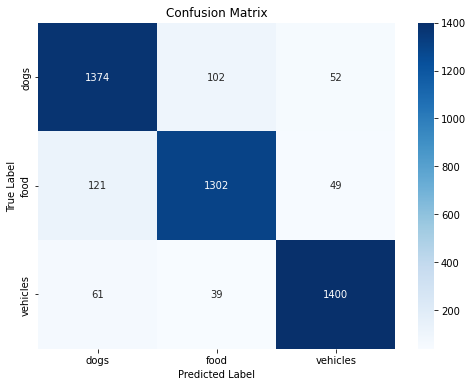

Precision: 0.9059
Recall: 0.9058
F1 Score: 0.9058


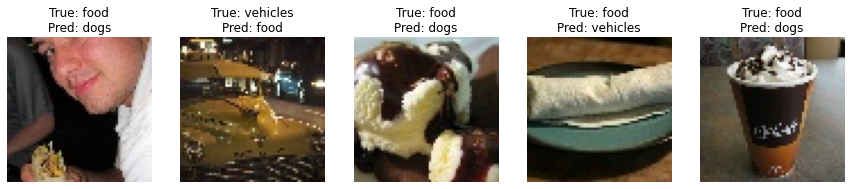

In [55]:
class_names = dataset.classes
plot_confusion_matrix(xe_sgd, test_loader, class_names)
evaluate_metrics(xe_sgd, test_loader)
show_misclassified_images(xe_sgd, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:15<00:00, 21.57batch/s, loss=0.552, lr=0.0001]


Epoch [1/10], Train Loss: 0.6902, Train Acc: 0.8587, Val Loss: 0.6931, Val Acc: 0.8582, Time: 17.9s


100%|██████████| 329/329 [00:15<00:00, 21.65batch/s, loss=0.668, lr=0.0001]


Epoch [2/10], Train Loss: 0.6938, Train Acc: 0.8556, Val Loss: 0.6858, Val Acc: 0.8653, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.62batch/s, loss=0.551, lr=1e-5]


Epoch [3/10], Train Loss: 0.6562, Train Acc: 0.8931, Val Loss: 0.6588, Val Acc: 0.8929, Time: 18.1s


100%|██████████| 329/329 [00:15<00:00, 21.27batch/s, loss=0.676, lr=1e-5]


Epoch [4/10], Train Loss: 0.6463, Train Acc: 0.9037, Val Loss: 0.6568, Val Acc: 0.8916, Time: 17.9s


100%|██████████| 329/329 [00:15<00:00, 21.05batch/s, loss=0.616, lr=1e-6]


Epoch [5/10], Train Loss: 0.6402, Train Acc: 0.9098, Val Loss: 0.6528, Val Acc: 0.8973, Time: 18.1s


100%|██████████| 329/329 [00:15<00:00, 21.10batch/s, loss=0.551, lr=1e-6]


Epoch [6/10], Train Loss: 0.6393, Train Acc: 0.9103, Val Loss: 0.6522, Val Acc: 0.8976, Time: 18.1s


100%|██████████| 329/329 [00:15<00:00, 20.86batch/s, loss=0.926, lr=1e-7]


Epoch [7/10], Train Loss: 0.6393, Train Acc: 0.9116, Val Loss: 0.6521, Val Acc: 0.8976, Time: 18.1s


100%|██████████| 329/329 [00:15<00:00, 21.60batch/s, loss=0.676, lr=1e-7]


Epoch [8/10], Train Loss: 0.6380, Train Acc: 0.9121, Val Loss: 0.6521, Val Acc: 0.8976, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.61batch/s, loss=0.67, lr=1e-8] 


Epoch [9/10], Train Loss: 0.6385, Train Acc: 0.9121, Val Loss: 0.6521, Val Acc: 0.8976, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.78batch/s, loss=0.672, lr=1e-8]


Epoch [10/10], Train Loss: 0.6381, Train Acc: 0.9125, Val Loss: 0.6521, Val Acc: 0.8976, Time: 17.4s


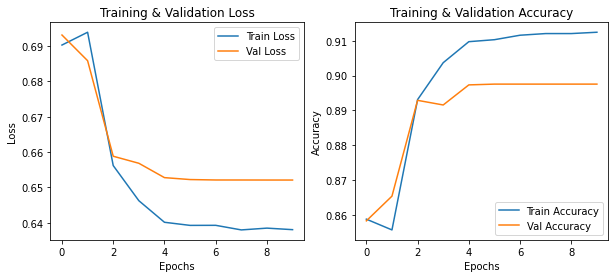

In [57]:
xe_adamw = VGG16C(num_classes=3).to(device)
xe_adamw.load_state_dict(torch.load("vgg16_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(xe_adamw.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_adamw, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_adamw.state_dict(), "vgg16_xe_adamw_model.pth")

In [58]:
test_model(xe_adamw, test_loader)

Test Loss: 0.6456, Test Accuracy: 0.9036


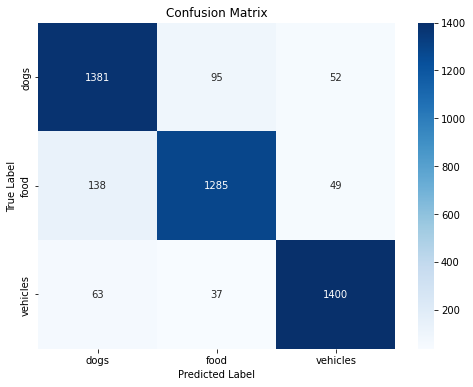

Precision: 0.9040
Recall: 0.9036
F1 Score: 0.9036


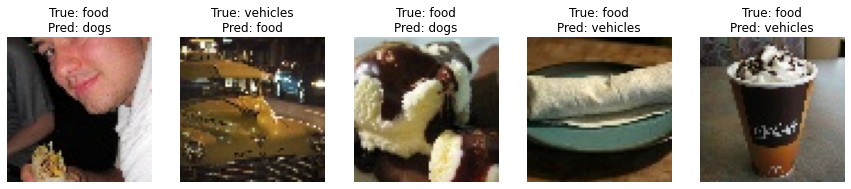

In [59]:
class_names = dataset.classes
plot_confusion_matrix(xe_adamw, test_loader, class_names)
evaluate_metrics(xe_adamw, test_loader)
show_misclassified_images(xe_adamw, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:14<00:00, 22.48batch/s, loss=0.786, lr=0.0001]


Epoch [1/10], Train Loss: 0.7239, Train Acc: 0.8265, Val Loss: 1.0260, Val Acc: 0.5244, Time: 16.9s


100%|██████████| 329/329 [00:15<00:00, 21.83batch/s, loss=0.676, lr=0.0001]


Epoch [2/10], Train Loss: 0.7775, Train Acc: 0.7731, Val Loss: 0.7401, Val Acc: 0.8107, Time: 17.3s


100%|██████████| 329/329 [00:14<00:00, 22.97batch/s, loss=0.801, lr=1e-5]


Epoch [3/10], Train Loss: 0.7048, Train Acc: 0.8467, Val Loss: 0.6906, Val Acc: 0.8611, Time: 16.6s


100%|██████████| 329/329 [00:14<00:00, 22.40batch/s, loss=0.676, lr=1e-5]


Epoch [4/10], Train Loss: 0.6867, Train Acc: 0.8644, Val Loss: 0.6841, Val Acc: 0.8676, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.22batch/s, loss=0.551, lr=1e-6]


Epoch [5/10], Train Loss: 0.6782, Train Acc: 0.8727, Val Loss: 0.6823, Val Acc: 0.8693, Time: 17.1s


100%|██████████| 329/329 [00:15<00:00, 21.60batch/s, loss=0.801, lr=1e-6]


Epoch [6/10], Train Loss: 0.6776, Train Acc: 0.8736, Val Loss: 0.6826, Val Acc: 0.8691, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.39batch/s, loss=0.551, lr=1e-7]


Epoch [7/10], Train Loss: 0.6752, Train Acc: 0.8757, Val Loss: 0.6825, Val Acc: 0.8693, Time: 17.7s


100%|██████████| 329/329 [00:14<00:00, 22.80batch/s, loss=0.551, lr=1e-7]


Epoch [8/10], Train Loss: 0.6754, Train Acc: 0.8754, Val Loss: 0.6819, Val Acc: 0.8696, Time: 16.8s


100%|██████████| 329/329 [00:14<00:00, 22.57batch/s, loss=0.801, lr=1e-8]


Epoch [9/10], Train Loss: 0.6762, Train Acc: 0.8753, Val Loss: 0.6819, Val Acc: 0.8696, Time: 16.9s


100%|██████████| 329/329 [00:14<00:00, 22.59batch/s, loss=0.551, lr=1e-8]


Epoch [10/10], Train Loss: 0.6755, Train Acc: 0.8752, Val Loss: 0.6819, Val Acc: 0.8696, Time: 16.9s


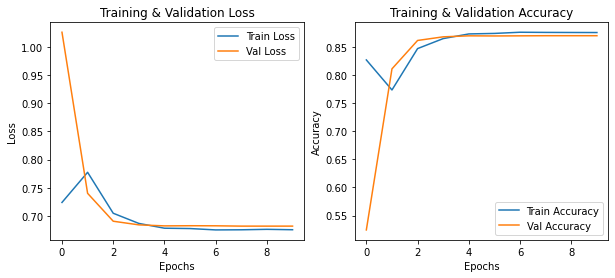

In [60]:
xe_rmsprops = VGG16C(num_classes=3).to(device)
xe_rmsprops.load_state_dict(torch.load("vgg16_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(xe_rmsprops.parameters(), lr=0.0001, alpha=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_rmsprops, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_rmsprops.state_dict(), "vgg16_xe_rms_model.pth")

In [61]:
test_model(xe_rmsprops, test_loader)

Test Loss: 0.6740, Test Accuracy: 0.8776


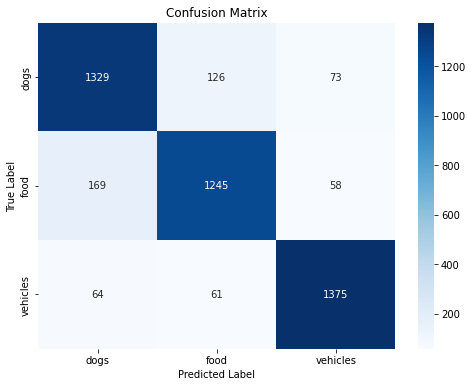

Precision: 0.8776
Recall: 0.8776
F1 Score: 0.8775


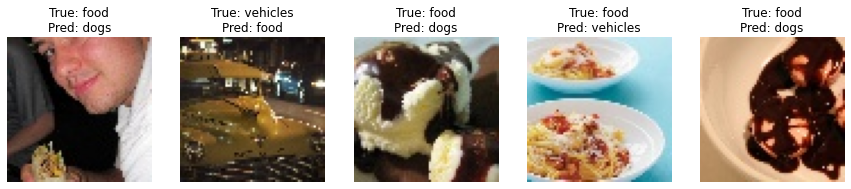

In [62]:
class_names = dataset.classes
plot_confusion_matrix(xe_rmsprops, test_loader, class_names)
evaluate_metrics(xe_rmsprops, test_loader)
show_misclassified_images(xe_rmsprops, test_loader, class_names, num_images=5)

<h3>Experimenting with 3 different optimiser for He initialisation

100%|██████████| 329/329 [00:14<00:00, 23.38batch/s, loss=0.555, lr=0.0001]


Epoch [1/10], Train Loss: 0.6548, Train Acc: 0.8942, Val Loss: 0.6637, Val Acc: 0.8853, Time: 16.3s


100%|██████████| 329/329 [00:13<00:00, 23.78batch/s, loss=0.678, lr=0.0001]


Epoch [2/10], Train Loss: 0.6563, Train Acc: 0.8934, Val Loss: 0.6632, Val Acc: 0.8873, Time: 16.1s


100%|██████████| 329/329 [00:13<00:00, 23.50batch/s, loss=0.551, lr=1e-5]


Epoch [3/10], Train Loss: 0.6460, Train Acc: 0.9044, Val Loss: 0.6600, Val Acc: 0.8907, Time: 16.3s


100%|██████████| 329/329 [00:13<00:00, 23.63batch/s, loss=0.801, lr=1e-5]


Epoch [4/10], Train Loss: 0.6454, Train Acc: 0.9060, Val Loss: 0.6609, Val Acc: 0.8889, Time: 16.2s


100%|██████████| 329/329 [00:14<00:00, 22.54batch/s, loss=0.676, lr=1e-6]


Epoch [5/10], Train Loss: 0.6442, Train Acc: 0.9070, Val Loss: 0.6604, Val Acc: 0.8889, Time: 16.9s


100%|██████████| 329/329 [00:13<00:00, 23.57batch/s, loss=0.551, lr=1e-6]


Epoch [6/10], Train Loss: 0.6437, Train Acc: 0.9068, Val Loss: 0.6605, Val Acc: 0.8889, Time: 16.2s


100%|██████████| 329/329 [00:14<00:00, 23.49batch/s, loss=0.585, lr=1e-7]


Epoch [7/10], Train Loss: 0.6437, Train Acc: 0.9072, Val Loss: 0.6605, Val Acc: 0.8887, Time: 16.3s


100%|██████████| 329/329 [00:13<00:00, 23.68batch/s, loss=0.552, lr=1e-7]


Epoch [8/10], Train Loss: 0.6437, Train Acc: 0.9070, Val Loss: 0.6605, Val Acc: 0.8887, Time: 16.2s


100%|██████████| 329/329 [00:14<00:00, 23.38batch/s, loss=0.571, lr=1e-8]


Epoch [9/10], Train Loss: 0.6436, Train Acc: 0.9076, Val Loss: 0.6605, Val Acc: 0.8887, Time: 16.5s


100%|██████████| 329/329 [00:14<00:00, 23.32batch/s, loss=0.679, lr=1e-8]


Epoch [10/10], Train Loss: 0.6443, Train Acc: 0.9065, Val Loss: 0.6605, Val Acc: 0.8887, Time: 16.5s


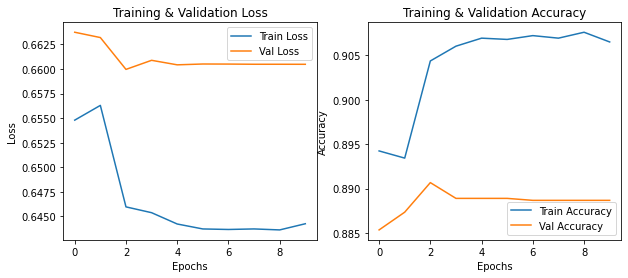

In [63]:
he_sgd = VGG16C(num_classes=3).to(device)
he_sgd.load_state_dict(torch.load("vgg16_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(he_sgd.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_sgd, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(he_sgd.state_dict(), "vgg16_he_sgd_model.pth")

In [64]:
test_model(he_sgd, test_loader)

Test Loss: 0.6491, Test Accuracy: 0.9004


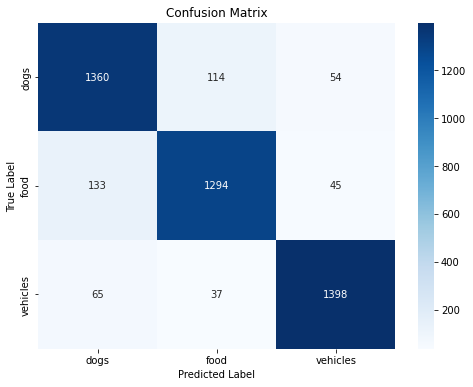

Precision: 0.9006
Recall: 0.9004
F1 Score: 0.9005


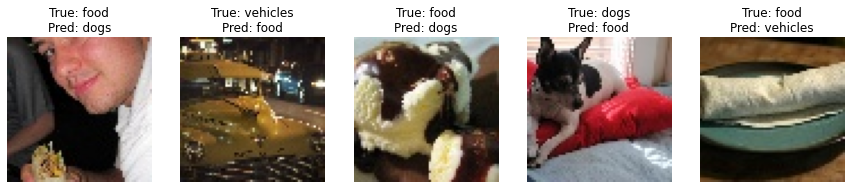

In [65]:
class_names = dataset.classes
plot_confusion_matrix(he_sgd, test_loader, class_names)
evaluate_metrics(he_sgd, test_loader)
show_misclassified_images(he_sgd, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:14<00:00, 22.04batch/s, loss=0.634, lr=0.0001]


Epoch [1/10], Train Loss: 0.7158, Train Acc: 0.8340, Val Loss: 0.7135, Val Acc: 0.8373, Time: 17.4s


100%|██████████| 329/329 [00:15<00:00, 21.73batch/s, loss=0.801, lr=0.0001]


Epoch [2/10], Train Loss: 0.7140, Train Acc: 0.8363, Val Loss: 0.7117, Val Acc: 0.8398, Time: 17.6s


100%|██████████| 329/329 [00:15<00:00, 21.67batch/s, loss=0.551, lr=1e-5]


Epoch [3/10], Train Loss: 0.6722, Train Acc: 0.8780, Val Loss: 0.6828, Val Acc: 0.8687, Time: 17.5s


100%|██████████| 329/329 [00:14<00:00, 21.99batch/s, loss=0.551, lr=1e-5]


Epoch [4/10], Train Loss: 0.6625, Train Acc: 0.8877, Val Loss: 0.6745, Val Acc: 0.8762, Time: 17.3s


100%|██████████| 329/329 [00:14<00:00, 22.10batch/s, loss=0.676, lr=1e-6]


Epoch [5/10], Train Loss: 0.6567, Train Acc: 0.8934, Val Loss: 0.6739, Val Acc: 0.8778, Time: 17.4s


100%|██████████| 329/329 [00:14<00:00, 22.02batch/s, loss=0.676, lr=1e-6]


Epoch [6/10], Train Loss: 0.6558, Train Acc: 0.8942, Val Loss: 0.6742, Val Acc: 0.8776, Time: 17.3s


100%|██████████| 329/329 [00:14<00:00, 22.22batch/s, loss=0.74, lr=1e-7] 


Epoch [7/10], Train Loss: 0.6544, Train Acc: 0.8961, Val Loss: 0.6742, Val Acc: 0.8769, Time: 17.1s


100%|██████████| 329/329 [00:15<00:00, 21.44batch/s, loss=0.801, lr=1e-7]


Epoch [8/10], Train Loss: 0.6545, Train Acc: 0.8965, Val Loss: 0.6742, Val Acc: 0.8771, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.47batch/s, loss=0.676, lr=1e-8]


Epoch [9/10], Train Loss: 0.6539, Train Acc: 0.8969, Val Loss: 0.6742, Val Acc: 0.8771, Time: 17.6s


100%|██████████| 329/329 [00:15<00:00, 21.86batch/s, loss=0.551, lr=1e-8]


Epoch [10/10], Train Loss: 0.6540, Train Acc: 0.8965, Val Loss: 0.6742, Val Acc: 0.8771, Time: 17.3s


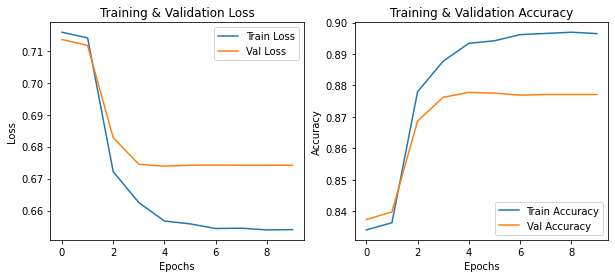

In [66]:
he_adamw = VGG16C(num_classes=3).to(device)
he_adamw.load_state_dict(torch.load("vgg16_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(he_adamw.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_adamw, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(he_adamw.state_dict(), "vgg16_he_adamw_model.pth")

In [67]:
test_model(he_adamw, test_loader)

Test Loss: 0.6607, Test Accuracy: 0.8898


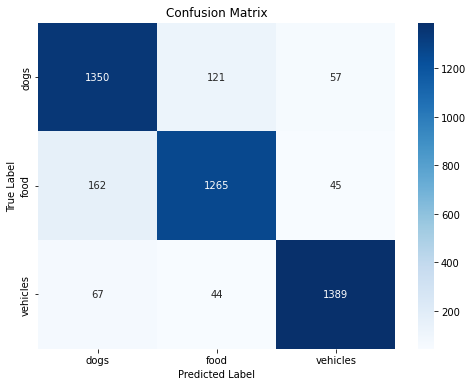

Precision: 0.8902
Recall: 0.8898
F1 Score: 0.8899


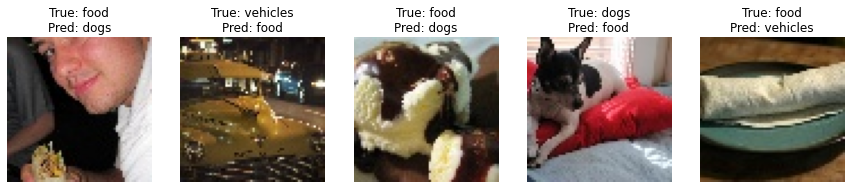

In [68]:
class_names = dataset.classes
plot_confusion_matrix(he_adamw, test_loader, class_names)
evaluate_metrics(he_adamw, test_loader)
show_misclassified_images(he_adamw, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:14<00:00, 22.14batch/s, loss=0.702, lr=0.0001]


Epoch [1/10], Train Loss: 0.7136, Train Acc: 0.8365, Val Loss: 0.9192, Val Acc: 0.6320, Time: 17.3s


100%|██████████| 329/329 [00:14<00:00, 22.74batch/s, loss=0.676, lr=0.0001]


Epoch [2/10], Train Loss: 0.7775, Train Acc: 0.7733, Val Loss: 0.7531, Val Acc: 0.7987, Time: 16.8s


100%|██████████| 329/329 [00:18<00:00, 17.75batch/s, loss=0.551, lr=1e-5]


Epoch [3/10], Train Loss: 0.7090, Train Acc: 0.8419, Val Loss: 0.7015, Val Acc: 0.8507, Time: 23.0s


100%|██████████| 329/329 [00:19<00:00, 17.22batch/s, loss=0.676, lr=1e-5]


Epoch [4/10], Train Loss: 0.6987, Train Acc: 0.8524, Val Loss: 0.6903, Val Acc: 0.8618, Time: 21.7s


100%|██████████| 329/329 [00:14<00:00, 22.62batch/s, loss=0.801, lr=1e-6]


Epoch [5/10], Train Loss: 0.6854, Train Acc: 0.8661, Val Loss: 0.6889, Val Acc: 0.8636, Time: 16.8s


100%|██████████| 329/329 [00:14<00:00, 22.08batch/s, loss=0.551, lr=1e-6]


Epoch [6/10], Train Loss: 0.6822, Train Acc: 0.8687, Val Loss: 0.6876, Val Acc: 0.8649, Time: 17.2s


100%|██████████| 329/329 [00:14<00:00, 22.98batch/s, loss=0.551, lr=1e-7]


Epoch [7/10], Train Loss: 0.6807, Train Acc: 0.8704, Val Loss: 0.6874, Val Acc: 0.8649, Time: 16.6s


100%|██████████| 329/329 [00:15<00:00, 20.76batch/s, loss=0.676, lr=1e-7]


Epoch [8/10], Train Loss: 0.6799, Train Acc: 0.8714, Val Loss: 0.6868, Val Acc: 0.8656, Time: 18.3s


100%|██████████| 329/329 [00:14<00:00, 22.60batch/s, loss=0.801, lr=1e-8]


Epoch [9/10], Train Loss: 0.6802, Train Acc: 0.8713, Val Loss: 0.6867, Val Acc: 0.8660, Time: 16.8s


100%|██████████| 329/329 [00:14<00:00, 22.89batch/s, loss=0.556, lr=1e-8]


Epoch [10/10], Train Loss: 0.6805, Train Acc: 0.8704, Val Loss: 0.6866, Val Acc: 0.8660, Time: 16.7s


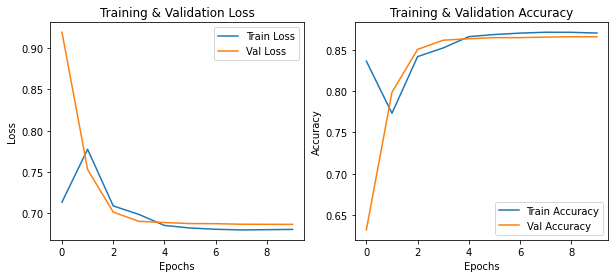

In [69]:

he_rmsprops = VGG16C(num_classes=3).to(device)
he_rmsprops.load_state_dict(torch.load("vgg16_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(he_rmsprops.parameters(), lr=0.0001, alpha=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_rmsprops, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(he_rmsprops.state_dict(), "vgg16_he_rms_model.pth")

In [70]:
test_model(he_rmsprops, test_loader)

Test Loss: 0.6832, Test Accuracy: 0.8682


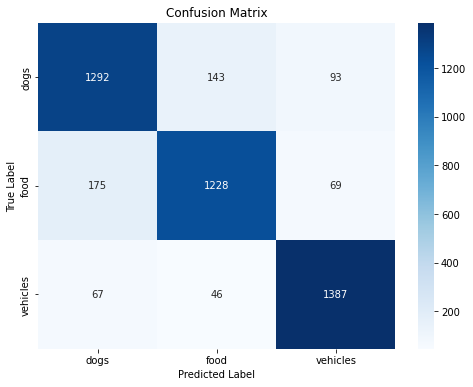

Precision: 0.8679
Recall: 0.8682
F1 Score: 0.8679


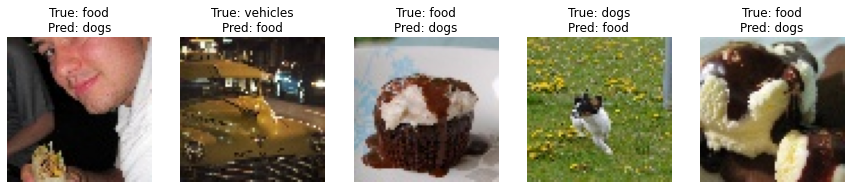

In [71]:
class_names = dataset.classes
plot_confusion_matrix(he_rmsprops, test_loader, class_names)
evaluate_metrics(he_rmsprops, test_loader)
show_misclassified_images(he_rmsprops, test_loader, class_names, num_images=5)

<h3> Xavier initialisation with SGD was the best model therefore all the batch size was experimented

100%|██████████| 657/657 [00:20<00:00, 31.51batch/s, loss=0.551, lr=0.0001]


Epoch [1/10], Train Loss: 0.6411, Train Acc: 0.9090, Val Loss: 0.6526, Val Acc: 0.8971, Time: 24.0s


100%|██████████| 657/657 [00:18<00:00, 34.81batch/s, loss=0.705, lr=0.0001]


Epoch [2/10], Train Loss: 0.6403, Train Acc: 0.9103, Val Loss: 0.6522, Val Acc: 0.8960, Time: 21.9s


100%|██████████| 657/657 [00:18<00:00, 36.00batch/s, loss=0.687, lr=1e-5]


Epoch [3/10], Train Loss: 0.6325, Train Acc: 0.9188, Val Loss: 0.6511, Val Acc: 0.8984, Time: 21.0s


100%|██████████| 657/657 [00:18<00:00, 35.81batch/s, loss=0.632, lr=1e-5]


Epoch [4/10], Train Loss: 0.6315, Train Acc: 0.9200, Val Loss: 0.6495, Val Acc: 0.9000, Time: 21.1s


100%|██████████| 657/657 [00:18<00:00, 35.13batch/s, loss=0.681, lr=1e-6]


Epoch [5/10], Train Loss: 0.6316, Train Acc: 0.9191, Val Loss: 0.6495, Val Acc: 0.8993, Time: 21.5s


100%|██████████| 657/657 [00:18<00:00, 35.46batch/s, loss=0.551, lr=1e-6]


Epoch [6/10], Train Loss: 0.6306, Train Acc: 0.9199, Val Loss: 0.6495, Val Acc: 0.8993, Time: 21.3s


100%|██████████| 657/657 [00:18<00:00, 35.85batch/s, loss=0.551, lr=1e-7]


Epoch [7/10], Train Loss: 0.6308, Train Acc: 0.9200, Val Loss: 0.6495, Val Acc: 0.8993, Time: 21.1s


100%|██████████| 657/657 [00:18<00:00, 35.91batch/s, loss=0.604, lr=1e-7]


Epoch [8/10], Train Loss: 0.6307, Train Acc: 0.9211, Val Loss: 0.6495, Val Acc: 0.8996, Time: 21.1s


100%|██████████| 657/657 [00:18<00:00, 35.60batch/s, loss=0.558, lr=1e-8]


Epoch [9/10], Train Loss: 0.6307, Train Acc: 0.9205, Val Loss: 0.6495, Val Acc: 0.8996, Time: 21.2s


100%|██████████| 657/657 [00:18<00:00, 35.44batch/s, loss=0.801, lr=1e-8]


Epoch [10/10], Train Loss: 0.6308, Train Acc: 0.9205, Val Loss: 0.6495, Val Acc: 0.8996, Time: 21.5s


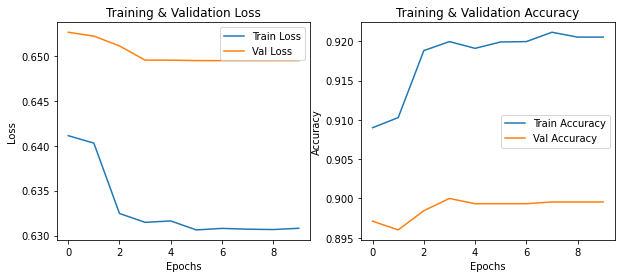

In [72]:
xe_sgd_32 = VGG16C(num_classes=3).to(device)
xe_sgd_32.load_state_dict(torch.load("vgg16_xe_sgd_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd_32.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd_32, train_loader32, val_loader32, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd_32.state_dict(), "vgg16_xe_sgd_32_model.pth")

In [73]:
test_model(xe_sgd_32, test_loader32)

Test Loss: 0.6427, Test Accuracy: 0.9096


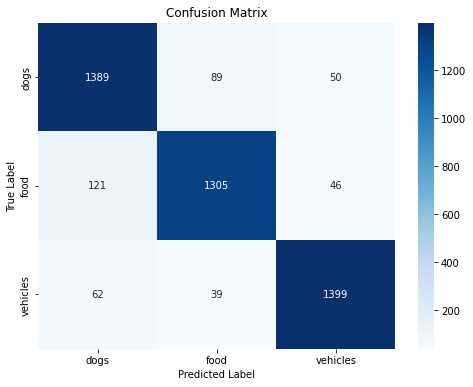

Precision: 0.9098
Recall: 0.9096
F1 Score: 0.9096


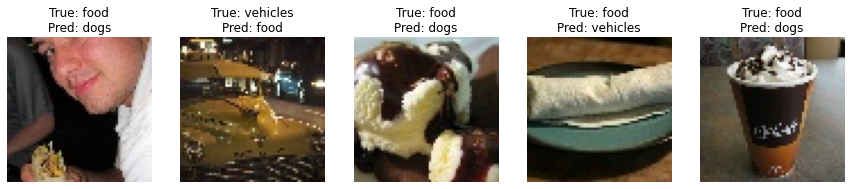

In [74]:
class_names = dataset.classes
plot_confusion_matrix(xe_sgd_32, test_loader32, class_names)
evaluate_metrics(xe_sgd_32, test_loader32)
show_misclassified_images(xe_sgd_32, test_loader32, class_names, num_images=5)

100%|██████████| 165/165 [00:12<00:00, 13.41batch/s, loss=0.669, lr=0.0001]


Epoch [1/10], Train Loss: 0.6343, Train Acc: 0.9174, Val Loss: 0.6526, Val Acc: 0.8982, Time: 14.5s


100%|██████████| 165/165 [00:12<00:00, 13.68batch/s, loss=0.676, lr=0.0001]


Epoch [2/10], Train Loss: 0.6343, Train Acc: 0.9168, Val Loss: 0.6556, Val Acc: 0.8958, Time: 14.4s


100%|██████████| 165/165 [00:12<00:00, 13.52batch/s, loss=0.555, lr=1e-5]


Epoch [3/10], Train Loss: 0.6319, Train Acc: 0.9189, Val Loss: 0.6509, Val Acc: 0.9009, Time: 14.3s


100%|██████████| 165/165 [00:12<00:00, 13.66batch/s, loss=0.653, lr=1e-5]


Epoch [4/10], Train Loss: 0.6315, Train Acc: 0.9198, Val Loss: 0.6513, Val Acc: 0.8998, Time: 14.2s


100%|██████████| 165/165 [00:12<00:00, 13.37batch/s, loss=0.551, lr=1e-6]


Epoch [5/10], Train Loss: 0.6308, Train Acc: 0.9204, Val Loss: 0.6512, Val Acc: 0.8993, Time: 14.6s


100%|██████████| 165/165 [00:12<00:00, 13.28batch/s, loss=0.551, lr=1e-6]


Epoch [6/10], Train Loss: 0.6305, Train Acc: 0.9201, Val Loss: 0.6511, Val Acc: 0.8996, Time: 14.6s


100%|██████████| 165/165 [00:12<00:00, 13.01batch/s, loss=0.676, lr=1e-7]


Epoch [7/10], Train Loss: 0.6312, Train Acc: 0.9209, Val Loss: 0.6511, Val Acc: 0.8996, Time: 15.2s


100%|██████████| 165/165 [00:13<00:00, 12.63batch/s, loss=0.554, lr=1e-7]


Epoch [8/10], Train Loss: 0.6308, Train Acc: 0.9201, Val Loss: 0.6511, Val Acc: 0.8998, Time: 15.2s


100%|██████████| 165/165 [00:12<00:00, 13.28batch/s, loss=0.551, lr=1e-8]


Epoch [9/10], Train Loss: 0.6305, Train Acc: 0.9202, Val Loss: 0.6511, Val Acc: 0.8998, Time: 14.6s


100%|██████████| 165/165 [00:11<00:00, 13.78batch/s, loss=0.556, lr=1e-8]


Epoch [10/10], Train Loss: 0.6306, Train Acc: 0.9204, Val Loss: 0.6511, Val Acc: 0.8998, Time: 14.3s


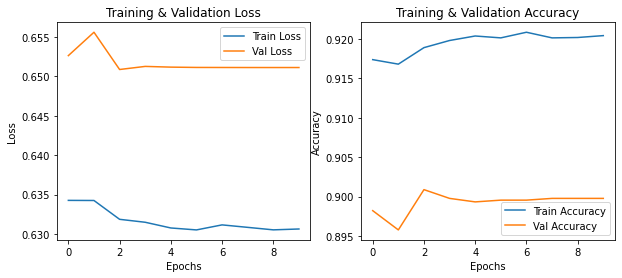

In [80]:
xe_sgd_128 = VGG16C(num_classes=3).to(device)
xe_sgd_128.load_state_dict(torch.load("vgg16_xe_sgd_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd_128.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd_128, train_loader128, val_loader128, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd_128.state_dict(), "vgg16_xe_sgd_128_model.pth")

In [81]:
test_model(xe_sgd_128, test_loader128)

Test Loss: 0.6446, Test Accuracy: 0.9062


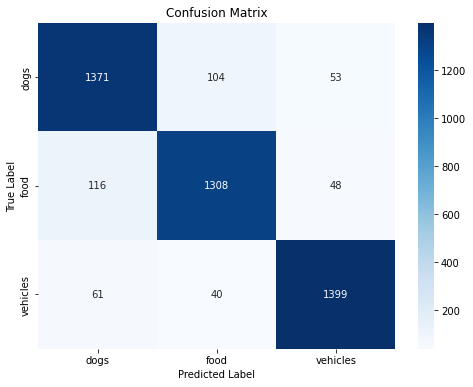

Precision: 0.9063
Recall: 0.9062
F1 Score: 0.9062


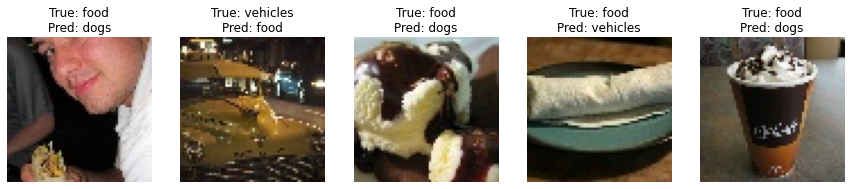

In [82]:
class_names = dataset.classes
plot_confusion_matrix(xe_sgd_128, test_loader128, class_names)
evaluate_metrics(xe_sgd_128, test_loader128)
show_misclassified_images(xe_sgd_128, test_loader128, class_names, num_images=5)

In [83]:
best=train_losses, val_losses, train_accs, val_accs

<h3> The batch size of 128 showed better accuracy now testing it with L2 Regularization

100%|██████████| 165/165 [00:12<00:00, 13.14batch/s, loss=0.552, lr=0.0001]


Epoch [1/10], Train Loss: 0.6330, Train Acc: 0.9170, Val Loss: 0.6524, Val Acc: 0.8976, Time: 14.8s


100%|██████████| 165/165 [00:12<00:00, 13.35batch/s, loss=0.551, lr=0.0001]


Epoch [2/10], Train Loss: 0.6324, Train Acc: 0.9184, Val Loss: 0.6535, Val Acc: 0.8980, Time: 14.4s


100%|██████████| 165/165 [00:12<00:00, 13.11batch/s, loss=0.551, lr=0.0001]


Epoch [3/10], Train Loss: 0.6327, Train Acc: 0.9172, Val Loss: 0.6507, Val Acc: 0.9007, Time: 14.7s


100%|██████████| 165/165 [00:13<00:00, 12.58batch/s, loss=0.551, lr=1e-5]


Epoch [4/10], Train Loss: 0.6301, Train Acc: 0.9209, Val Loss: 0.6506, Val Acc: 0.9000, Time: 15.3s


100%|██████████| 165/165 [00:13<00:00, 12.31batch/s, loss=0.551, lr=1e-5]


Epoch [5/10], Train Loss: 0.6304, Train Acc: 0.9202, Val Loss: 0.6510, Val Acc: 0.8998, Time: 16.1s


100%|██████████| 165/165 [00:12<00:00, 12.97batch/s, loss=0.923, lr=1e-5]


Epoch [6/10], Train Loss: 0.6318, Train Acc: 0.9211, Val Loss: 0.6504, Val Acc: 0.9004, Time: 15.0s


100%|██████████| 165/165 [00:13<00:00, 12.43batch/s, loss=0.551, lr=1e-6]


Epoch [7/10], Train Loss: 0.6298, Train Acc: 0.9211, Val Loss: 0.6505, Val Acc: 0.8996, Time: 16.2s


100%|██████████| 165/165 [00:12<00:00, 12.85batch/s, loss=0.763, lr=1e-6]


Epoch [8/10], Train Loss: 0.6311, Train Acc: 0.9205, Val Loss: 0.6506, Val Acc: 0.8996, Time: 14.9s


100%|██████████| 165/165 [00:12<00:00, 13.48batch/s, loss=0.552, lr=1e-6]


Epoch [9/10], Train Loss: 0.6295, Train Acc: 0.9215, Val Loss: 0.6506, Val Acc: 0.9000, Time: 14.4s


100%|██████████| 165/165 [00:12<00:00, 13.48batch/s, loss=0.677, lr=1e-7]


Epoch [10/10], Train Loss: 0.6303, Train Acc: 0.9213, Val Loss: 0.6506, Val Acc: 0.9000, Time: 14.3s


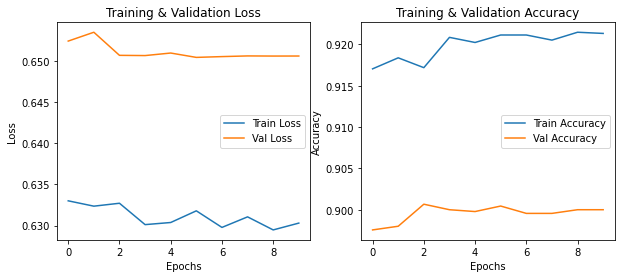

In [86]:
xe_sgd_128_l2 = VGG16C(num_classes=3).to(device)
xe_sgd_128_l2.load_state_dict(torch.load("vgg16_xe_sgd_128_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd_128_l2.parameters(), lr=0.0001,momentum = 0.9, weight_decay=1e-4)  # L2 Regularization

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd_128_l2, train_loader128, val_loader128, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd_128_l2.state_dict(), "vgg16_xe_sgd_128_l2_model.pth")

In [87]:
test_model(xe_sgd_128_l2, test_loader128)

Test Loss: 0.6442, Test Accuracy: 0.9071


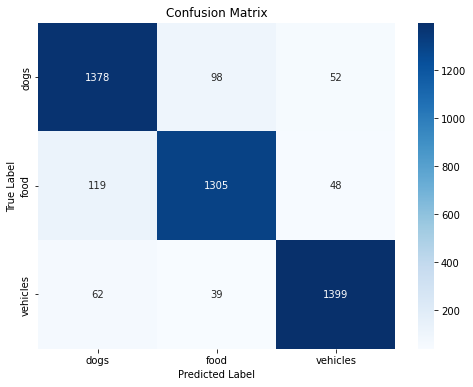

Precision: 0.9073
Recall: 0.9071
F1 Score: 0.9071


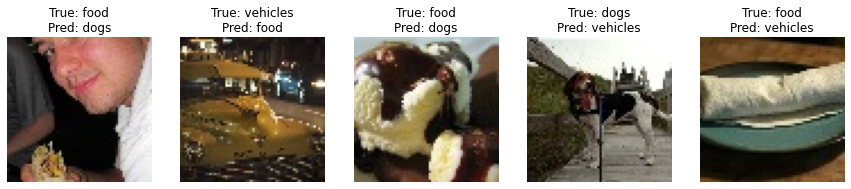

In [88]:
class_names = dataset.classes
plot_confusion_matrix(xe_sgd_128_l2, test_loader128, class_names)
evaluate_metrics(xe_sgd_128_l2, test_loader128)
show_misclassified_images(xe_sgd_128_l2, test_loader128, class_names, num_images=5)

<h3>Tensorboard Output

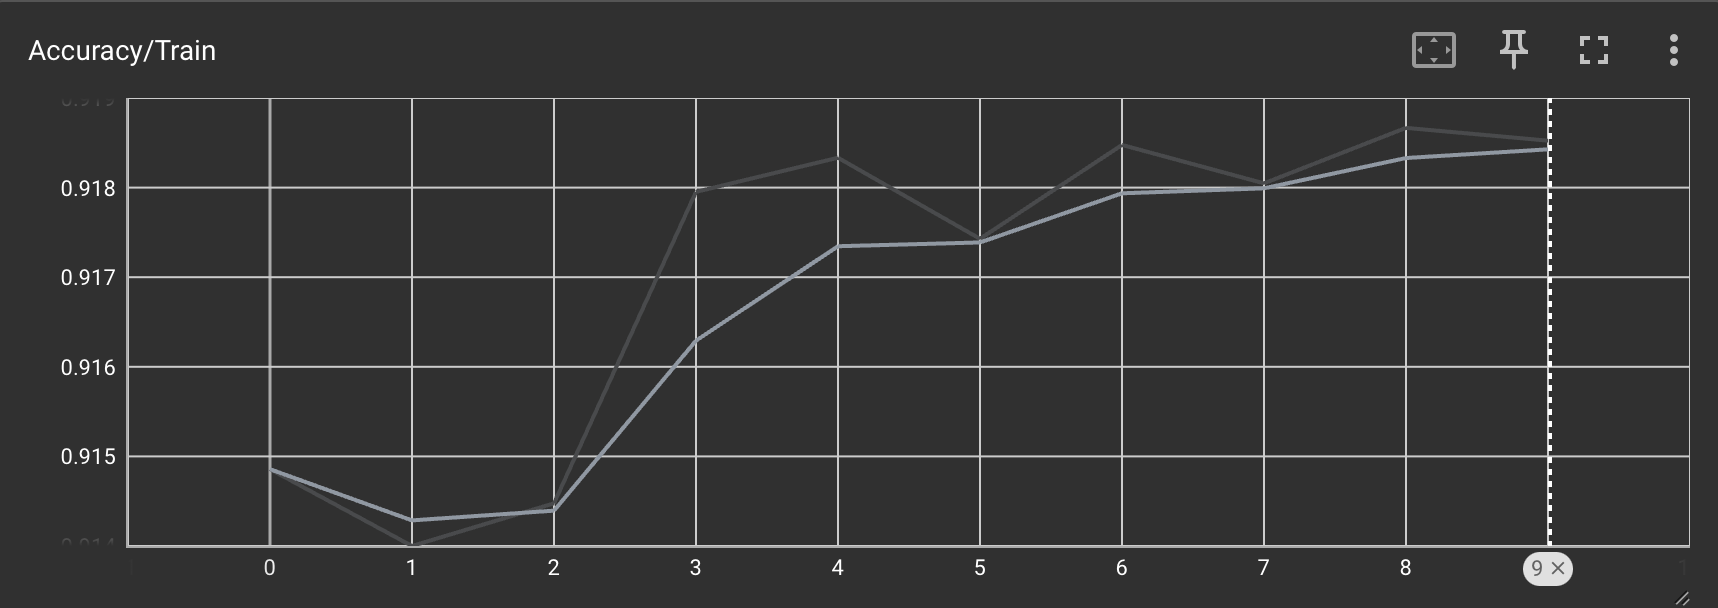 
Training Accuracy over Epooch

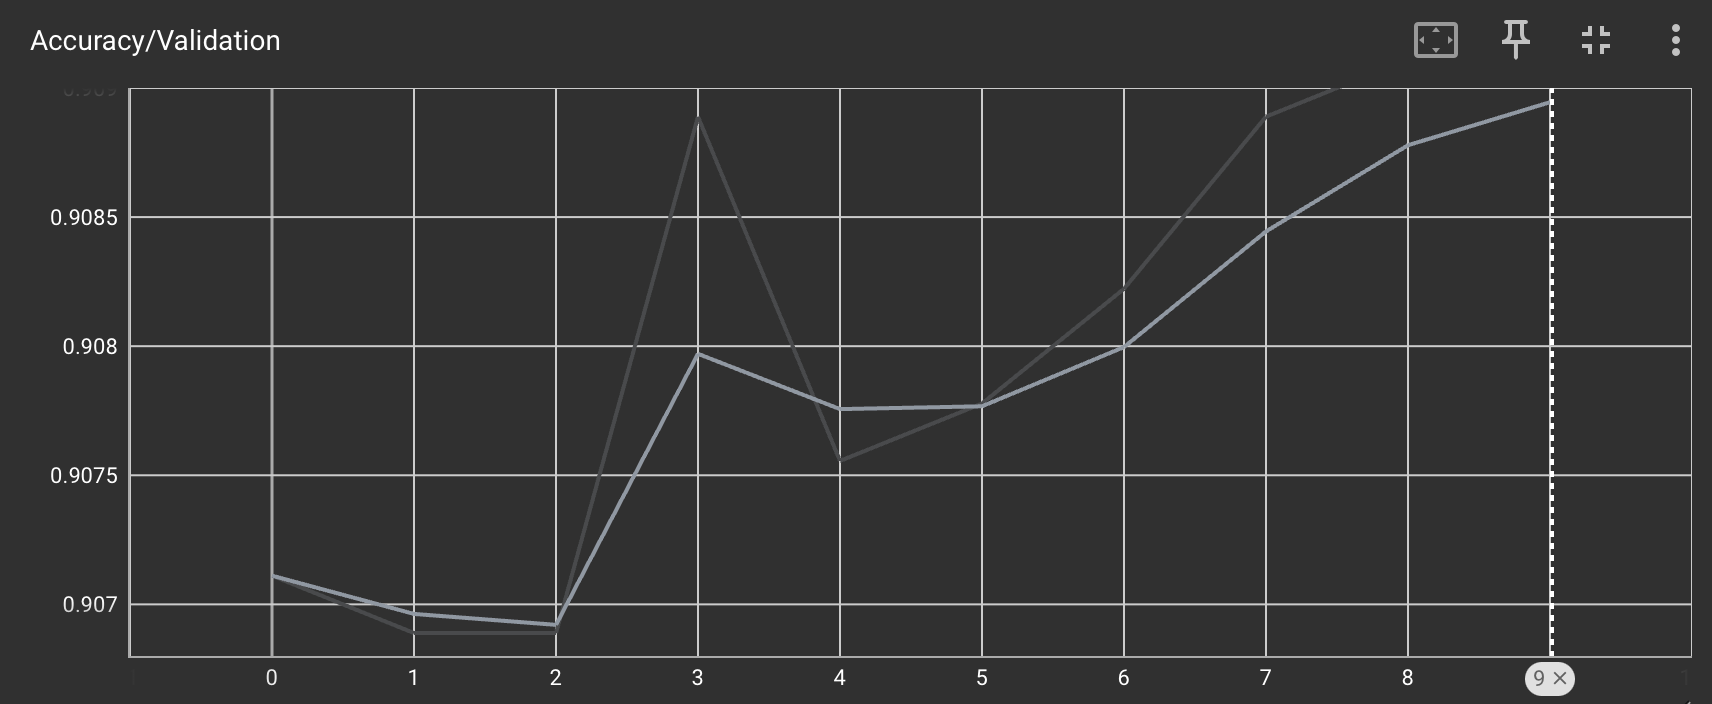

Validation Accuracy over Epooch

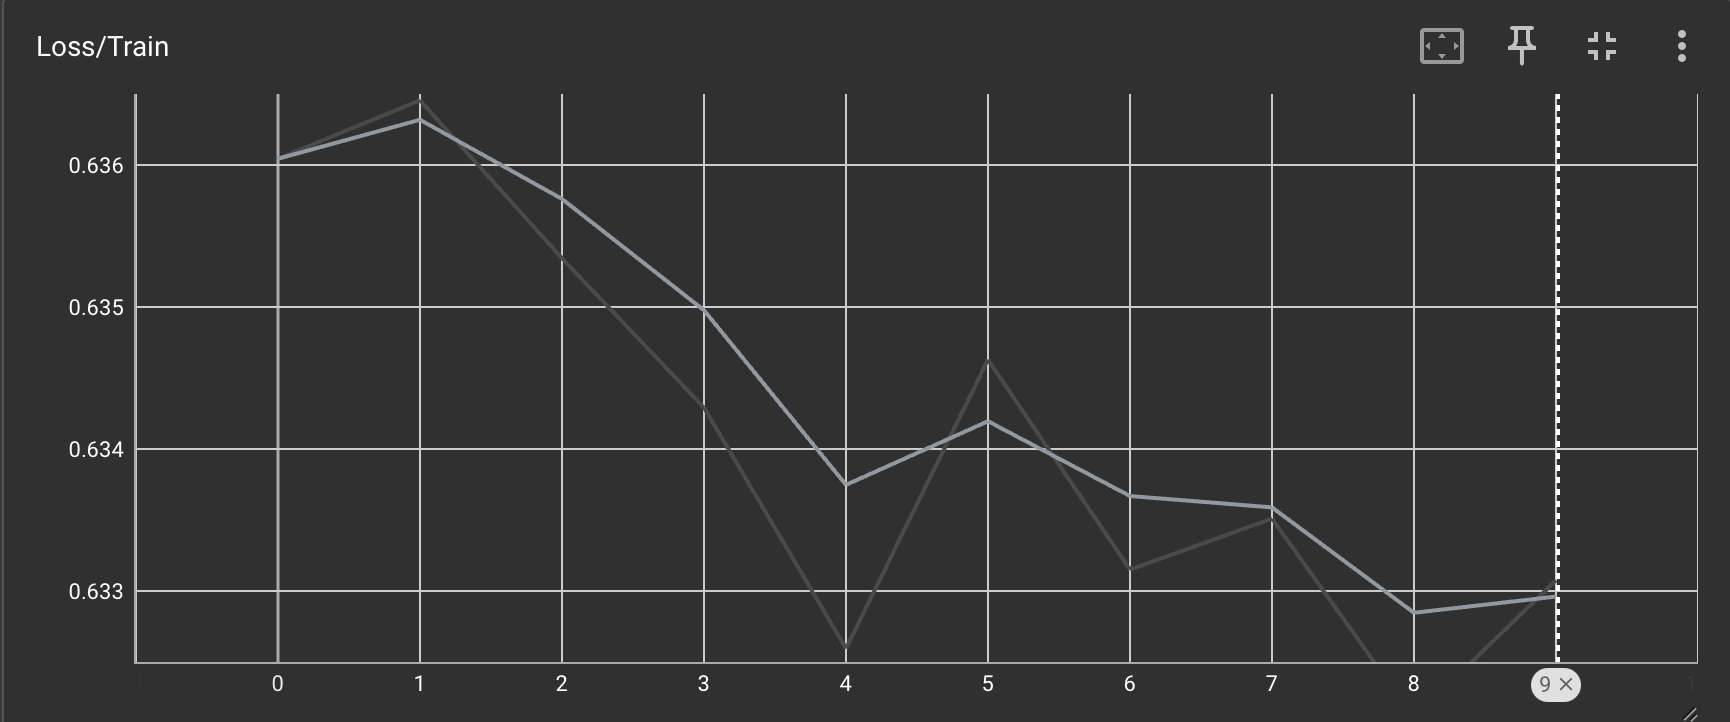

Training Loss over Epooch

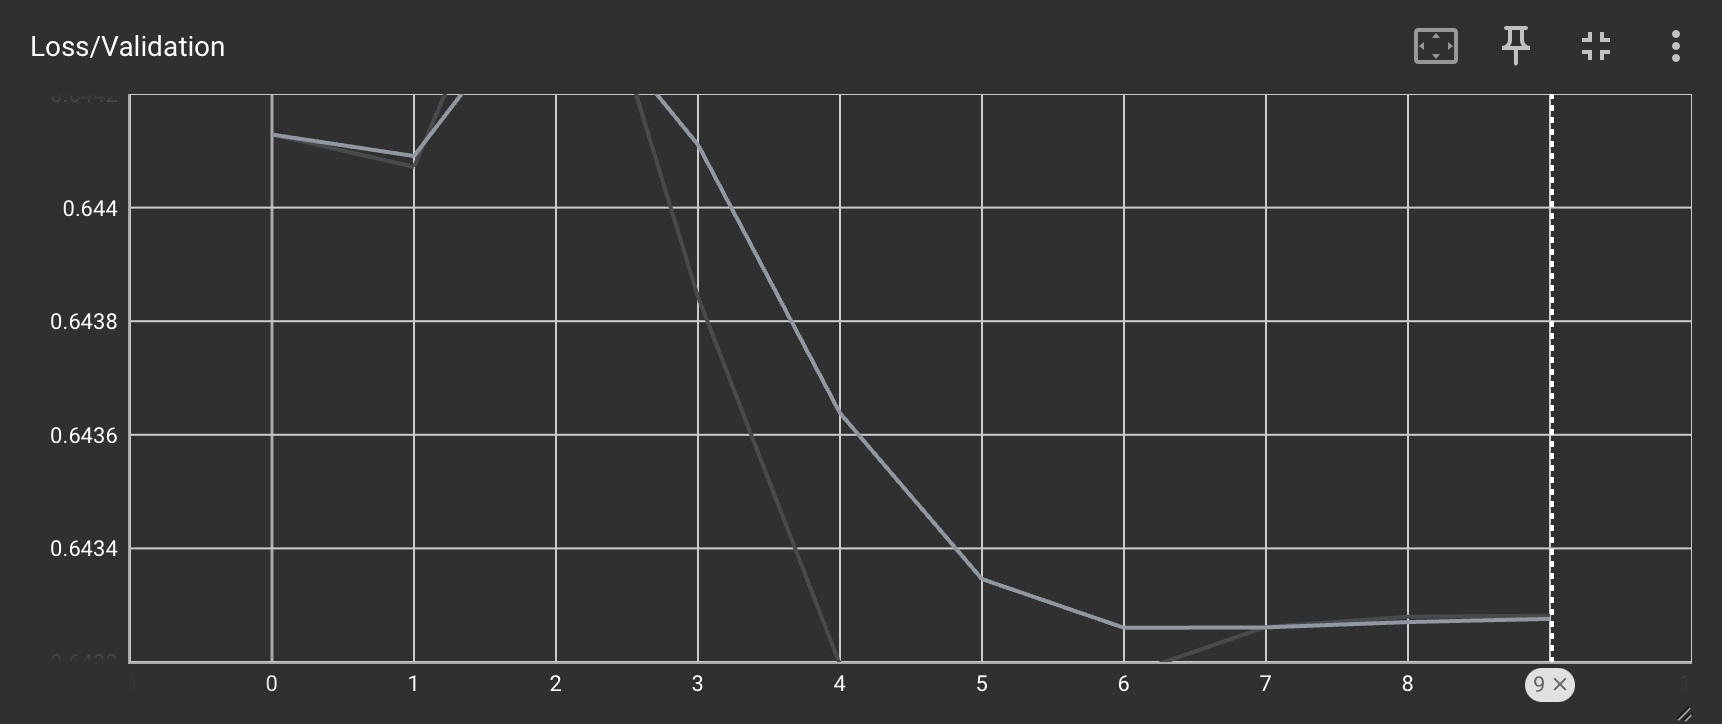

Validation loss over Epooch

In [89]:
best = train_losses, val_losses, train_accs, val_accs 

<H3>Early Stopping

#early stop
xe_sgd_128_l2_es = VGG16C(num_classes=3).to(device)
xe_sgd_128_l2_es.load_state_dict(torch.load("vgg16_xe_sgd_128_l2_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd_128_l2_es.parameters(), lr=0.0001,momentum = 0.9, weight_decay=1e-4)  # L2 Regularization

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = ES_train_model(xe_sgd_128_l2_es, train_loader128, val_loader128, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd_128_l2_es.state_dict(), "vgg16_xe_sgd_128_l2_es_model.pth")

In [94]:
test_model(xe_sgd_128_l2_es,test_loader128)

Test Loss: 0.6435, Test Accuracy: 0.9073


<h3>Image augmentation

100%|██████████| 165/165 [00:17<00:00,  9.25batch/s, loss=0.552, lr=0.0001]


Epoch [1/10], Train Loss: 0.8458, Train Acc: 0.7025, Val Loss: 0.7223, Val Acc: 0.8256, Time: 22.1s


100%|██████████| 165/165 [00:15<00:00, 10.63batch/s, loss=0.554, lr=0.0001]


Epoch [2/10], Train Loss: 0.7036, Train Acc: 0.8447, Val Loss: 0.7005, Val Acc: 0.8493, Time: 18.3s


100%|██████████| 165/165 [00:15<00:00, 10.32batch/s, loss=0.551, lr=0.0001]


Epoch [3/10], Train Loss: 0.6897, Train Acc: 0.8594, Val Loss: 0.6934, Val Acc: 0.8553, Time: 19.3s


100%|██████████| 165/165 [00:15<00:00, 10.47batch/s, loss=0.676, lr=1e-5]


Epoch [4/10], Train Loss: 0.6848, Train Acc: 0.8646, Val Loss: 0.6883, Val Acc: 0.8604, Time: 18.8s


100%|██████████| 165/165 [00:16<00:00,  9.77batch/s, loss=0.676, lr=1e-5]


Epoch [5/10], Train Loss: 0.6811, Train Acc: 0.8679, Val Loss: 0.6832, Val Acc: 0.8660, Time: 19.8s


100%|██████████| 165/165 [00:15<00:00, 10.54batch/s, loss=0.801, lr=1e-5]


Epoch [6/10], Train Loss: 0.6824, Train Acc: 0.8680, Val Loss: 0.6828, Val Acc: 0.8653, Time: 18.9s


100%|██████████| 165/165 [00:15<00:00, 10.47batch/s, loss=0.676, lr=1e-6]


Epoch [7/10], Train Loss: 0.6798, Train Acc: 0.8695, Val Loss: 0.6811, Val Acc: 0.8696, Time: 18.5s


100%|██████████| 165/165 [00:16<00:00,  9.90batch/s, loss=0.551, lr=1e-6]


Epoch [8/10], Train Loss: 0.6794, Train Acc: 0.8696, Val Loss: 0.6861, Val Acc: 0.8647, Time: 19.5s


100%|██████████| 165/165 [00:15<00:00, 10.47batch/s, loss=0.676, lr=1e-6]


Epoch [9/10], Train Loss: 0.6805, Train Acc: 0.8687, Val Loss: 0.6830, Val Acc: 0.8680, Time: 18.5s


100%|██████████| 165/165 [00:15<00:00, 10.64batch/s, loss=0.676, lr=1e-7]


Epoch [10/10], Train Loss: 0.6797, Train Acc: 0.8693, Val Loss: 0.6842, Val Acc: 0.8660, Time: 18.4s


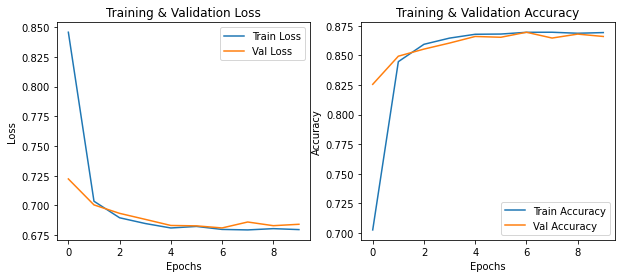

In [95]:
xe_sgd_128_l2_data = VGG16C(num_classes=3).to(device)
xe_sgd_128_l2_data.load_state_dict(torch.load("vgg16_xe_sgd_128_l2_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd_128_l2_data.parameters(), lr=0.0001,momentum = 0.9, weight_decay=1e-4) 

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd_128_l2_data, train_loader128_aug, val_loader128_aug, criterion, optimizer, scheduler, num_epochs)
loss_acc()
torch.save(xe_sgd_128_l2_data.state_dict(), "vgg16_xe_sgd_128_l2_data_model.pth")

In [96]:

test_model(xe_sgd_128_l2_data,test_loader128_aug)

Test Loss: 0.6866, Test Accuracy: 0.8613


<h3>Data augmentation hasn't drastically improved the accuracy of the model ,best VGG model was xavier with sgd and batch = 128 with L2 regularization at 90%

## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [97]:
### ADD YOUR CODE HERE ###


import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

2. Assemble the ResNet-18 architecture.

In [98]:
### ADD YOUR CODE HERE ###

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):  
        super(ResNet, self).__init__()
        self.inplanes = 64
        
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
       
        x = self.conv1(x)     
        x = self.maxpool(x)   
        
        
        x = self.layer0(x)    
        x = self.layer1(x)   
        x = self.layer2(x)    
        x = self.layer3(x)    
        
        
        x = self.avgpool(x)  
        x = x.view(x.size(0), -1)
        x = self.fc(x)        
        return x

def resnet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])


<h3>He Initialisation

3. Train the ResNet-18 model.

100%|██████████| 329/329 [00:16<00:00, 19.90batch/s, loss=0.557, lr=0.0001]


Epoch [1/10], Train Loss: 0.8514, Train Acc: 0.6401, Val Loss: 0.6820, Val Acc: 0.7373, Time: 19.2s


100%|██████████| 329/329 [00:15<00:00, 20.95batch/s, loss=0.485, lr=0.0001]


Epoch [2/10], Train Loss: 0.5934, Train Acc: 0.7639, Val Loss: 0.5387, Val Acc: 0.7831, Time: 18.4s


100%|██████████| 329/329 [00:15<00:00, 20.68batch/s, loss=0.668, lr=0.0001]


Epoch [3/10], Train Loss: 0.5067, Train Acc: 0.7972, Val Loss: 0.4823, Val Acc: 0.8067, Time: 18.8s


100%|██████████| 329/329 [00:17<00:00, 18.83batch/s, loss=0.573, lr=0.0001]


Epoch [4/10], Train Loss: 0.4593, Train Acc: 0.8183, Val Loss: 0.4405, Val Acc: 0.8260, Time: 20.2s


100%|██████████| 329/329 [00:16<00:00, 20.48batch/s, loss=0.495, lr=0.0001]


Epoch [5/10], Train Loss: 0.4174, Train Acc: 0.8324, Val Loss: 0.4024, Val Acc: 0.8418, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 20.51batch/s, loss=0.531, lr=1e-5]


Epoch [6/10], Train Loss: 0.3979, Train Acc: 0.8434, Val Loss: 0.4015, Val Acc: 0.8429, Time: 18.6s


100%|██████████| 329/329 [00:16<00:00, 19.63batch/s, loss=0.606, lr=1e-5]


Epoch [7/10], Train Loss: 0.3907, Train Acc: 0.8451, Val Loss: 0.3948, Val Acc: 0.8444, Time: 19.5s


100%|██████████| 329/329 [00:16<00:00, 19.76batch/s, loss=0.17, lr=1e-5] 


Epoch [8/10], Train Loss: 0.3901, Train Acc: 0.8472, Val Loss: 0.3919, Val Acc: 0.8473, Time: 19.4s


100%|██████████| 329/329 [00:16<00:00, 20.17batch/s, loss=0.786, lr=1e-5]


Epoch [9/10], Train Loss: 0.3851, Train Acc: 0.8514, Val Loss: 0.3940, Val Acc: 0.8402, Time: 20.2s


100%|██████████| 329/329 [00:15<00:00, 20.64batch/s, loss=0.942, lr=1e-5]


Epoch [10/10], Train Loss: 0.3822, Train Acc: 0.8523, Val Loss: 0.3854, Val Acc: 0.8498, Time: 18.7s


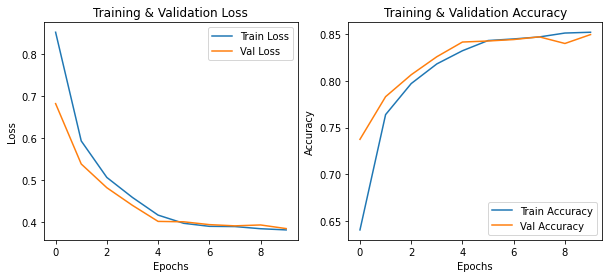

In [100]:
### ADD YOUR CODE HERE ###

he_init_resnet_model = resnet18().to(device)
he_init_resnet_model.apply(he_init)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(he_init_resnet_model.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_init_resnet_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [101]:
test_model(he_init_resnet_model, test_loader)

Test Loss: 0.3809, Test Accuracy: 0.8578


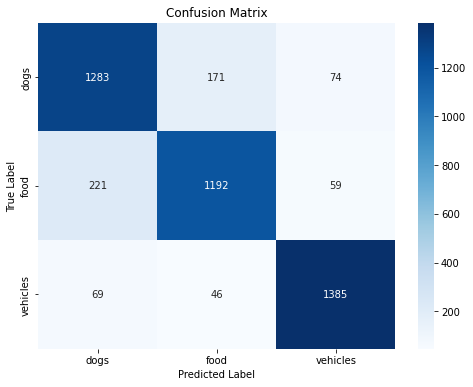

Precision: 0.8578
Recall: 0.8578
F1 Score: 0.8576


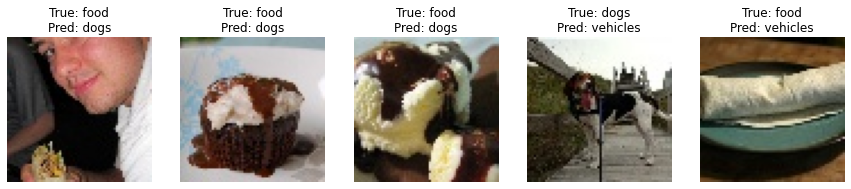

In [102]:
class_names = dataset.classes
plot_confusion_matrix(he_init_resnet_model, test_loader, class_names)
evaluate_metrics(he_init_resnet_model, test_loader)
show_misclassified_images(he_init_resnet_model, test_loader, class_names, num_images=5)

<h3>Xavier Initialisatiom

100%|██████████| 329/329 [00:16<00:00, 20.45batch/s, loss=0.757, lr=0.0001]


Epoch [1/10], Train Loss: 0.8627, Train Acc: 0.6395, Val Loss: 0.7207, Val Acc: 0.7189, Time: 19.0s


100%|██████████| 329/329 [00:15<00:00, 20.59batch/s, loss=0.728, lr=0.0001]


Epoch [2/10], Train Loss: 0.6339, Train Acc: 0.7462, Val Loss: 0.5859, Val Acc: 0.7653, Time: 18.7s


100%|██████████| 329/329 [00:16<00:00, 20.18batch/s, loss=0.621, lr=0.0001]


Epoch [3/10], Train Loss: 0.5424, Train Acc: 0.7796, Val Loss: 0.5208, Val Acc: 0.7896, Time: 19.0s


100%|██████████| 329/329 [00:16<00:00, 20.11batch/s, loss=0.599, lr=0.0001]


Epoch [4/10], Train Loss: 0.4838, Train Acc: 0.8069, Val Loss: 0.4716, Val Acc: 0.8120, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 19.91batch/s, loss=0.815, lr=0.0001]


Epoch [5/10], Train Loss: 0.4425, Train Acc: 0.8243, Val Loss: 0.4401, Val Acc: 0.8329, Time: 19.1s


100%|██████████| 329/329 [00:16<00:00, 19.55batch/s, loss=0.428, lr=1e-5]


Epoch [6/10], Train Loss: 0.4210, Train Acc: 0.8340, Val Loss: 0.4319, Val Acc: 0.8287, Time: 19.6s


100%|██████████| 329/329 [00:15<00:00, 20.79batch/s, loss=0.251, lr=1e-5]


Epoch [7/10], Train Loss: 0.4145, Train Acc: 0.8362, Val Loss: 0.4310, Val Acc: 0.8233, Time: 19.0s


100%|██████████| 329/329 [00:16<00:00, 20.44batch/s, loss=0.659, lr=1e-5]


Epoch [8/10], Train Loss: 0.4154, Train Acc: 0.8360, Val Loss: 0.4226, Val Acc: 0.8331, Time: 19.2s


100%|██████████| 329/329 [00:15<00:00, 20.99batch/s, loss=0.482, lr=1e-5]


Epoch [9/10], Train Loss: 0.4078, Train Acc: 0.8393, Val Loss: 0.4258, Val Acc: 0.8313, Time: 18.3s


100%|██████████| 329/329 [00:16<00:00, 20.44batch/s, loss=0.608, lr=1e-5]


Epoch [10/10], Train Loss: 0.4076, Train Acc: 0.8404, Val Loss: 0.4202, Val Acc: 0.8311, Time: 19.1s


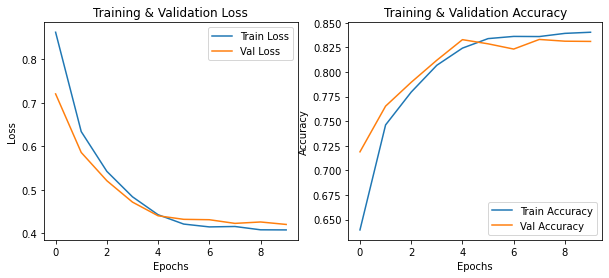

In [103]:
xe_init_resnet_model = resnet18().to(device)
xe_init_resnet_model.apply(xavier_init)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_init_resnet_model.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_init_resnet_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [104]:
test_model(xe_init_resnet_model, test_loader)

Test Loss: 0.4001, Test Accuracy: 0.8442


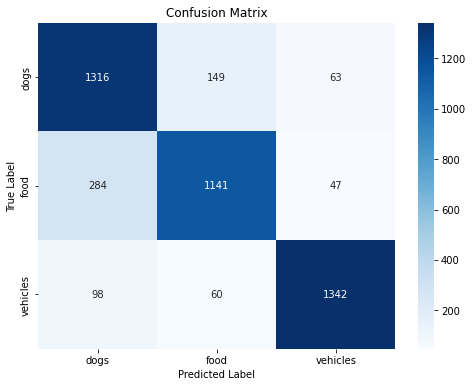

Precision: 0.8477
Recall: 0.8442
F1 Score: 0.8446


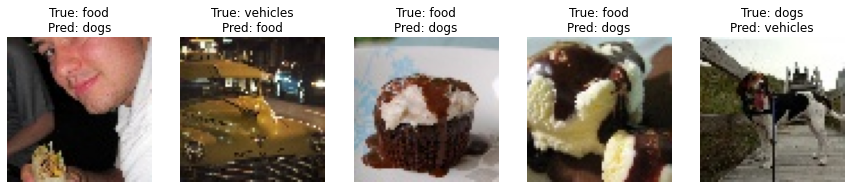

In [105]:
class_names = dataset.classes
plot_confusion_matrix(xe_init_resnet_model, test_loader, class_names)
evaluate_metrics(xe_init_resnet_model, test_loader)
show_misclassified_images(xe_init_resnet_model, test_loader, class_names, num_images=5)

In [106]:
torch.save(xe_init_resnet_model.state_dict(), "resnet_xe_init_model.pth")
torch.save(he_init_resnet_model.state_dict(), "resnet_he_init_model.pth")

<h3>Xavier Init with different optimiser

100%|██████████| 329/329 [00:16<00:00, 19.67batch/s, loss=0.489, lr=0.001]


Epoch [1/10], Train Loss: 0.4106, Train Acc: 0.8427, Val Loss: 0.6564, Val Acc: 0.7796, Time: 19.4s


100%|██████████| 329/329 [00:16<00:00, 19.99batch/s, loss=1.17, lr=0.001] 


Epoch [2/10], Train Loss: 0.2790, Train Acc: 0.8950, Val Loss: 0.5077, Val Acc: 0.8011, Time: 19.6s


100%|██████████| 329/329 [00:16<00:00, 19.93batch/s, loss=0.877, lr=0.001] 


Epoch [3/10], Train Loss: 0.2416, Train Acc: 0.9097, Val Loss: 0.2966, Val Acc: 0.8964, Time: 19.1s


100%|██████████| 329/329 [00:16<00:00, 20.27batch/s, loss=0.114, lr=0.0001] 


Epoch [4/10], Train Loss: 0.1599, Train Acc: 0.9422, Val Loss: 0.1662, Val Acc: 0.9358, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 19.48batch/s, loss=0.328, lr=0.0001] 


Epoch [5/10], Train Loss: 0.1350, Train Acc: 0.9487, Val Loss: 0.1689, Val Acc: 0.9396, Time: 19.7s


100%|██████████| 329/329 [00:16<00:00, 19.78batch/s, loss=0.0774, lr=0.0001]


Epoch [6/10], Train Loss: 0.1209, Train Acc: 0.9545, Val Loss: 0.1553, Val Acc: 0.9416, Time: 19.3s


100%|██████████| 329/329 [00:16<00:00, 19.72batch/s, loss=0.73, lr=1e-5]  


Epoch [7/10], Train Loss: 0.1026, Train Acc: 0.9637, Val Loss: 0.1598, Val Acc: 0.9427, Time: 19.3s


100%|██████████| 329/329 [00:16<00:00, 19.94batch/s, loss=0.0259, lr=1e-5]


Epoch [8/10], Train Loss: 0.0940, Train Acc: 0.9660, Val Loss: 0.1470, Val Acc: 0.9478, Time: 19.3s


100%|██████████| 329/329 [00:16<00:00, 19.52batch/s, loss=0.408, lr=1e-5] 


Epoch [9/10], Train Loss: 0.0965, Train Acc: 0.9652, Val Loss: 0.1548, Val Acc: 0.9429, Time: 19.5s


100%|██████████| 329/329 [00:16<00:00, 19.97batch/s, loss=0.284, lr=1e-6] 


Epoch [10/10], Train Loss: 0.0932, Train Acc: 0.9669, Val Loss: 0.1471, Val Acc: 0.9473, Time: 19.3s


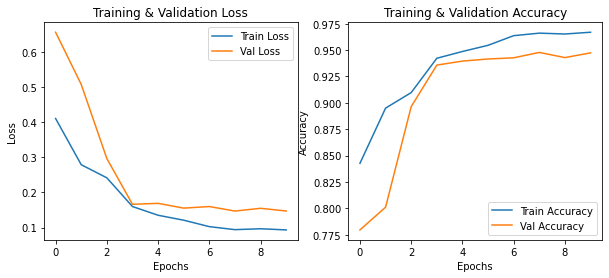

In [107]:
xe_adam = resnet18().to(device)
xe_adam.load_state_dict(torch.load("resnet_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xe_adam.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_adam, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [109]:
test_model(xe_adam, test_loader)

Test Loss: 0.1405, Test Accuracy: 0.9482


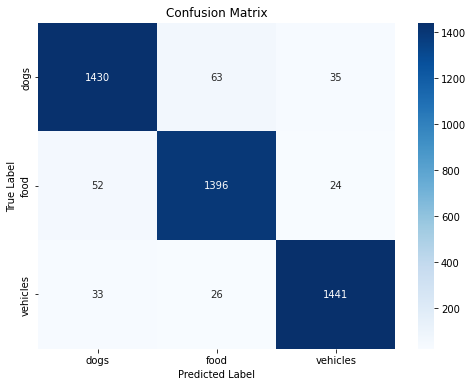

Precision: 0.9482
Recall: 0.9482
F1 Score: 0.9482


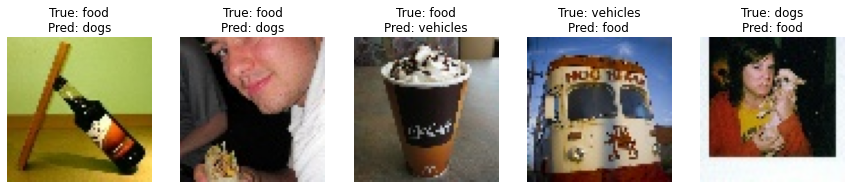

In [110]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam, test_loader, class_names)
evaluate_metrics(xe_adam, test_loader)
show_misclassified_images(xe_adam, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:15<00:00, 20.80batch/s, loss=0.437, lr=0.0001]


Epoch [1/10], Train Loss: 0.3682, Train Acc: 0.8554, Val Loss: 0.9069, Val Acc: 0.7269, Time: 18.4s


100%|██████████| 329/329 [00:16<00:00, 19.67batch/s, loss=0.681, lr=0.0001] 


Epoch [2/10], Train Loss: 0.2341, Train Acc: 0.9107, Val Loss: 3.4240, Val Acc: 0.4842, Time: 19.3s


100%|██████████| 329/329 [00:16<00:00, 20.26batch/s, loss=0.234, lr=1e-5] 


Epoch [3/10], Train Loss: 0.0820, Train Acc: 0.9743, Val Loss: 0.2963, Val Acc: 0.9029, Time: 18.9s


100%|██████████| 329/329 [00:15<00:00, 20.85batch/s, loss=0.344, lr=1e-5]  


Epoch [4/10], Train Loss: 0.0369, Train Acc: 0.9901, Val Loss: 0.3338, Val Acc: 0.8969, Time: 18.7s


100%|██████████| 329/329 [00:15<00:00, 20.72batch/s, loss=0.158, lr=1e-6]  


Epoch [5/10], Train Loss: 0.0195, Train Acc: 0.9970, Val Loss: 0.3209, Val Acc: 0.9020, Time: 18.7s


100%|██████████| 329/329 [00:16<00:00, 20.34batch/s, loss=0.0466, lr=1e-6] 


Epoch [6/10], Train Loss: 0.0170, Train Acc: 0.9980, Val Loss: 0.3255, Val Acc: 0.9020, Time: 18.8s


100%|██████████| 329/329 [00:16<00:00, 20.56batch/s, loss=0.209, lr=1e-7]  


Epoch [7/10], Train Loss: 0.0169, Train Acc: 0.9976, Val Loss: 0.3243, Val Acc: 0.8996, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 19.70batch/s, loss=0.00889, lr=1e-7]


Epoch [8/10], Train Loss: 0.0159, Train Acc: 0.9973, Val Loss: 0.3263, Val Acc: 0.9033, Time: 19.4s


100%|██████████| 329/329 [00:16<00:00, 20.56batch/s, loss=0.0442, lr=1e-8] 


Epoch [9/10], Train Loss: 0.0168, Train Acc: 0.9975, Val Loss: 0.3222, Val Acc: 0.9018, Time: 18.5s


100%|██████████| 329/329 [00:16<00:00, 20.56batch/s, loss=0.236, lr=1e-8]  


Epoch [10/10], Train Loss: 0.0168, Train Acc: 0.9975, Val Loss: 0.3264, Val Acc: 0.9031, Time: 18.6s


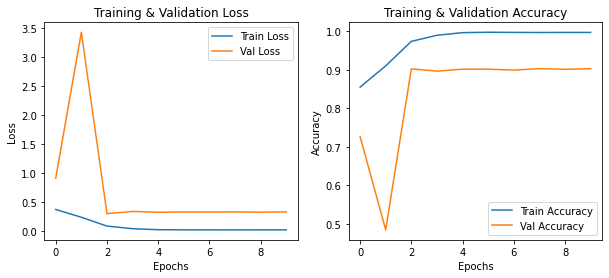

In [111]:
xe_rmsprops = resnet18().to(device)
xe_rmsprops.load_state_dict(torch.load("resnet_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(xe_rmsprops.parameters(), lr=0.0001, alpha=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_rmsprops, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
# torch.save(xe_sgd.state_dict(), "vgg16_xe_sgd_model.pth")

In [112]:
test_model(xe_rmsprops, test_loader)

Test Loss: 0.3066, Test Accuracy: 0.9071


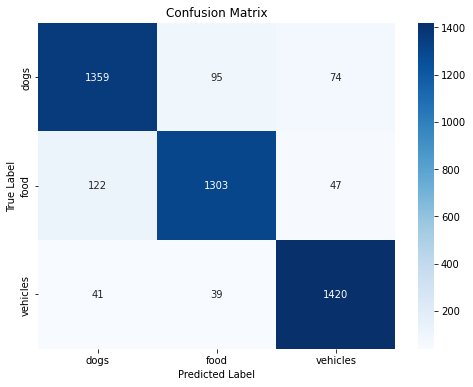

Precision: 0.9070
Recall: 0.9071
F1 Score: 0.9069


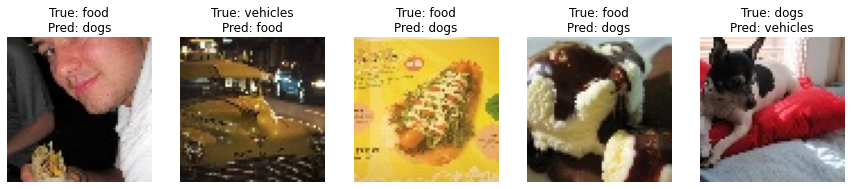

In [113]:
class_names = dataset.classes
plot_confusion_matrix(xe_rmsprops, test_loader, class_names)
evaluate_metrics(xe_rmsprops, test_loader)
show_misclassified_images(xe_rmsprops, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:22<00:00, 14.33batch/s, loss=0.586, lr=0.0001]


Epoch [1/10], Train Loss: 0.3926, Train Acc: 0.8445, Val Loss: 0.3960, Val Acc: 0.8391, Time: 28.2s


100%|██████████| 329/329 [00:17<00:00, 19.06batch/s, loss=0.484, lr=0.0001]


Epoch [2/10], Train Loss: 0.3683, Train Acc: 0.8573, Val Loss: 0.3780, Val Acc: 0.8518, Time: 19.8s


100%|██████████| 329/329 [00:15<00:00, 21.44batch/s, loss=0.592, lr=1e-5]


Epoch [3/10], Train Loss: 0.3536, Train Acc: 0.8630, Val Loss: 0.3690, Val Acc: 0.8540, Time: 17.9s


100%|██████████| 329/329 [00:15<00:00, 21.01batch/s, loss=0.33, lr=1e-5] 


Epoch [4/10], Train Loss: 0.3522, Train Acc: 0.8645, Val Loss: 0.3653, Val Acc: 0.8533, Time: 18.1s


100%|██████████| 329/329 [00:14<00:00, 22.22batch/s, loss=0.255, lr=1e-6]


Epoch [5/10], Train Loss: 0.3492, Train Acc: 0.8665, Val Loss: 0.3638, Val Acc: 0.8540, Time: 17.3s


100%|██████████| 329/329 [00:15<00:00, 21.88batch/s, loss=0.373, lr=1e-6]


Epoch [6/10], Train Loss: 0.3495, Train Acc: 0.8643, Val Loss: 0.3670, Val Acc: 0.8551, Time: 17.7s


100%|██████████| 329/329 [00:15<00:00, 21.43batch/s, loss=0.971, lr=1e-7]


Epoch [7/10], Train Loss: 0.3526, Train Acc: 0.8640, Val Loss: 0.3685, Val Acc: 0.8556, Time: 17.8s


100%|██████████| 329/329 [00:15<00:00, 21.87batch/s, loss=0.674, lr=1e-7]


Epoch [8/10], Train Loss: 0.3482, Train Acc: 0.8655, Val Loss: 0.3701, Val Acc: 0.8529, Time: 17.5s


100%|██████████| 329/329 [00:15<00:00, 21.54batch/s, loss=0.528, lr=1e-8]


Epoch [9/10], Train Loss: 0.3486, Train Acc: 0.8662, Val Loss: 0.3653, Val Acc: 0.8542, Time: 17.8s


100%|██████████| 329/329 [00:15<00:00, 21.58batch/s, loss=0.431, lr=1e-8]


Epoch [10/10], Train Loss: 0.3453, Train Acc: 0.8671, Val Loss: 0.3703, Val Acc: 0.8527, Time: 17.7s


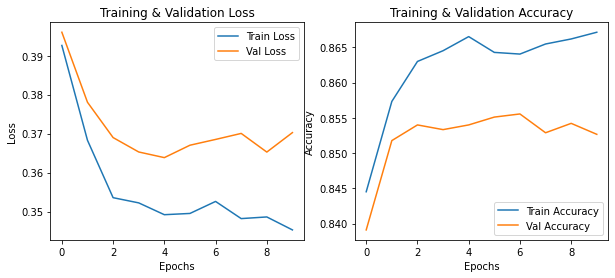

In [114]:
xe_sgd = resnet18().to(device)
xe_sgd.load_state_dict(torch.load("resnet_xe_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xe_sgd.parameters(), lr=0.0001, momentum =0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_sgd, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
# torch.save(xe_sgd.state_dict(), "vgg16_xe_sgd_model.pth")

In [115]:
test_model(xe_sgd, test_loader)

Test Loss: 0.3549, Test Accuracy: 0.8620


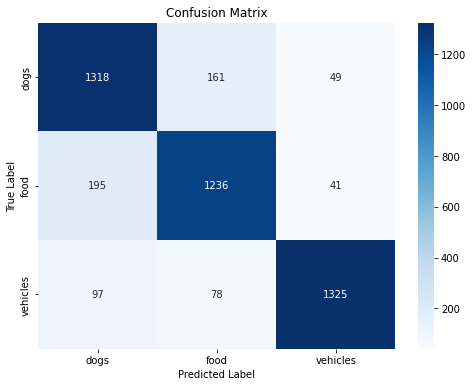

Precision: 0.8642
Recall: 0.8620
F1 Score: 0.8627


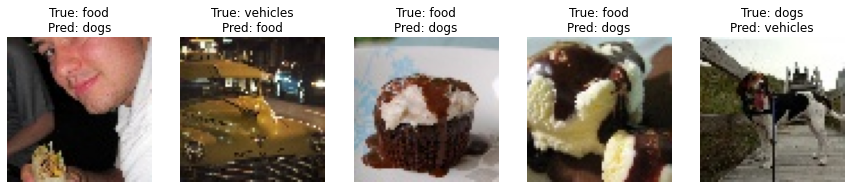

In [116]:
class_names = dataset.classes
plot_confusion_matrix(xe_sgd, test_loader, class_names)
evaluate_metrics(xe_sgd, test_loader)
show_misclassified_images(xe_sgd, test_loader, class_names, num_images=5)

<h3>He init with different optimiser

100%|██████████| 329/329 [00:21<00:00, 15.02batch/s, loss=0.324, lr=0.0001]


Epoch [1/10], Train Loss: 0.3735, Train Acc: 0.8522, Val Loss: 0.3790, Val Acc: 0.8447, Time: 25.2s


100%|██████████| 329/329 [00:15<00:00, 21.04batch/s, loss=0.145, lr=0.0001]


Epoch [2/10], Train Loss: 0.3516, Train Acc: 0.8648, Val Loss: 0.3621, Val Acc: 0.8622, Time: 18.2s


100%|██████████| 329/329 [00:15<00:00, 20.79batch/s, loss=0.338, lr=0.0001]


Epoch [3/10], Train Loss: 0.3307, Train Acc: 0.8729, Val Loss: 0.3931, Val Acc: 0.8462, Time: 18.5s


100%|██████████| 329/329 [00:15<00:00, 21.02batch/s, loss=0.0733, lr=0.0001]


Epoch [4/10], Train Loss: 0.3163, Train Acc: 0.8782, Val Loss: 0.3337, Val Acc: 0.8729, Time: 18.1s


100%|██████████| 329/329 [00:16<00:00, 20.23batch/s, loss=0.377, lr=0.0001]


Epoch [5/10], Train Loss: 0.3046, Train Acc: 0.8825, Val Loss: 0.3237, Val Acc: 0.8769, Time: 18.9s


100%|██████████| 329/329 [00:15<00:00, 20.83batch/s, loss=0.669, lr=1e-5]


Epoch [6/10], Train Loss: 0.2895, Train Acc: 0.8913, Val Loss: 0.3160, Val Acc: 0.8796, Time: 18.3s


100%|██████████| 329/329 [00:16<00:00, 20.11batch/s, loss=1.03, lr=1e-5] 


Epoch [7/10], Train Loss: 0.2884, Train Acc: 0.8917, Val Loss: 0.3155, Val Acc: 0.8787, Time: 19.0s


100%|██████████| 329/329 [00:15<00:00, 21.20batch/s, loss=0.209, lr=1e-5]


Epoch [8/10], Train Loss: 0.2840, Train Acc: 0.8922, Val Loss: 0.3113, Val Acc: 0.8807, Time: 18.1s


100%|██████████| 329/329 [00:15<00:00, 21.20batch/s, loss=0.932, lr=1e-5]


Epoch [9/10], Train Loss: 0.2855, Train Acc: 0.8920, Val Loss: 0.3143, Val Acc: 0.8813, Time: 18.0s


100%|██████████| 329/329 [00:15<00:00, 20.74batch/s, loss=0.457, lr=1e-5]


Epoch [10/10], Train Loss: 0.2857, Train Acc: 0.8926, Val Loss: 0.3097, Val Acc: 0.8829, Time: 18.4s


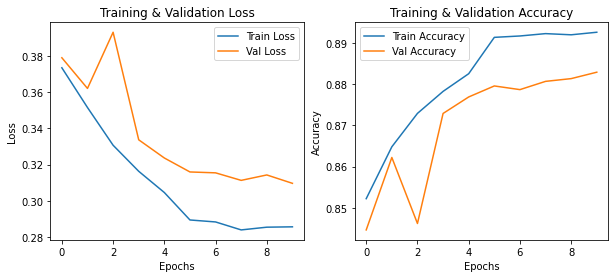

In [117]:
he_sgd = resnet18().to(device)
he_sgd.load_state_dict(torch.load("resnet_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(he_sgd.parameters(), lr=0.0001, momentum = 0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_sgd, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [118]:
test_model(he_sgd, test_loader)

Test Loss: 0.3021, Test Accuracy: 0.8893


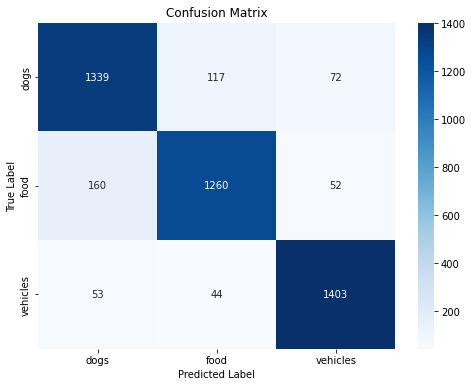

Precision: 0.8893
Recall: 0.8893
F1 Score: 0.8892


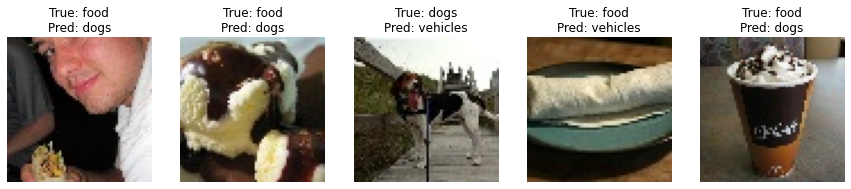

In [119]:
class_names = dataset.classes
plot_confusion_matrix(he_sgd, test_loader, class_names)
evaluate_metrics(he_sgd, test_loader)
show_misclassified_images(he_sgd, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:16<00:00, 20.31batch/s, loss=0.629, lr=0.0001]


Epoch [1/10], Train Loss: 0.3434, Train Acc: 0.8707, Val Loss: 0.2840, Val Acc: 0.8956, Time: 19.8s


100%|██████████| 329/329 [00:16<00:00, 19.87batch/s, loss=0.321, lr=0.0001] 


Epoch [2/10], Train Loss: 0.2198, Train Acc: 0.9183, Val Loss: 0.3185, Val Acc: 0.8838, Time: 19.7s


100%|██████████| 329/329 [00:16<00:00, 20.15batch/s, loss=0.0144, lr=0.0001]


Epoch [3/10], Train Loss: 0.1143, Train Acc: 0.9582, Val Loss: 0.3422, Val Acc: 0.8876, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 19.59batch/s, loss=0.431, lr=0.0001]  


Epoch [4/10], Train Loss: 0.0634, Train Acc: 0.9790, Val Loss: 0.5570, Val Acc: 0.8578, Time: 19.4s


100%|██████████| 329/329 [00:16<00:00, 20.28batch/s, loss=0.12, lr=0.0001]   


Epoch [5/10], Train Loss: 0.0573, Train Acc: 0.9801, Val Loss: 0.4207, Val Acc: 0.8907, Time: 18.8s


100%|██████████| 329/329 [00:16<00:00, 20.32batch/s, loss=1.76, lr=1e-5]    


Epoch [6/10], Train Loss: 0.0193, Train Acc: 0.9959, Val Loss: 0.3641, Val Acc: 0.9038, Time: 18.8s


100%|██████████| 329/329 [00:16<00:00, 19.62batch/s, loss=0.149, lr=1e-5]   


Epoch [7/10], Train Loss: 0.0081, Train Acc: 0.9987, Val Loss: 0.3660, Val Acc: 0.9058, Time: 19.5s


100%|██████████| 329/329 [00:16<00:00, 19.49batch/s, loss=0.00381, lr=1e-5] 


Epoch [8/10], Train Loss: 0.0056, Train Acc: 0.9993, Val Loss: 0.3584, Val Acc: 0.9071, Time: 19.5s


100%|██████████| 329/329 [00:17<00:00, 19.27batch/s, loss=0.0924, lr=1e-5]  


Epoch [9/10], Train Loss: 0.0052, Train Acc: 0.9993, Val Loss: 0.3721, Val Acc: 0.9029, Time: 19.8s


100%|██████████| 329/329 [00:16<00:00, 19.91batch/s, loss=0.00194, lr=1e-5] 


Epoch [10/10], Train Loss: 0.0029, Train Acc: 0.9998, Val Loss: 0.3634, Val Acc: 0.9078, Time: 19.2s


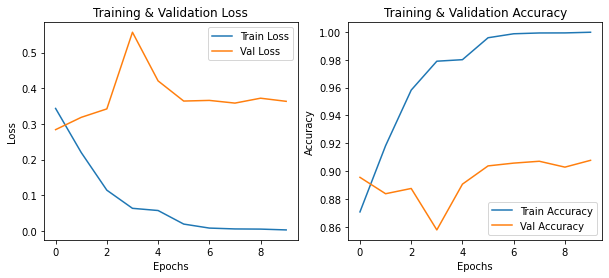

In [120]:
he_adam = resnet18().to(device)
he_adam.load_state_dict(torch.load("resnet_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(he_adam.parameters(), lr=0.0001) 

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_adam, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [121]:
test_model(he_adam, test_loader)

Test Loss: 0.3373, Test Accuracy: 0.9151


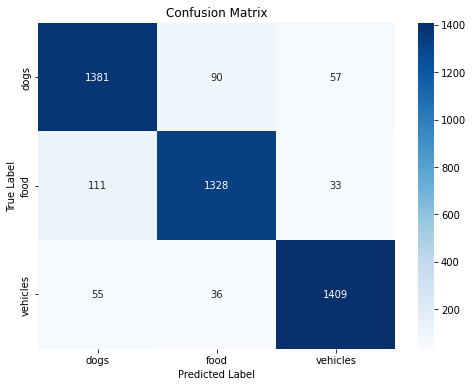

Precision: 0.9152
Recall: 0.9151
F1 Score: 0.9151


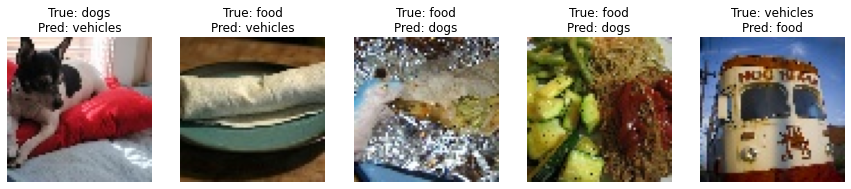

In [122]:
class_names = dataset.classes
plot_confusion_matrix(he_adam, test_loader, class_names)
evaluate_metrics(he_adam, test_loader)
show_misclassified_images(he_adam, test_loader, class_names, num_images=5)

100%|██████████| 329/329 [00:16<00:00, 20.01batch/s, loss=0.219, lr=0.0001]


Epoch [1/10], Train Loss: 0.3518, Train Acc: 0.8639, Val Loss: 0.3115, Val Acc: 0.8860, Time: 19.1s


100%|██████████| 329/329 [00:16<00:00, 20.20batch/s, loss=0.26, lr=0.0001]  


Epoch [2/10], Train Loss: 0.2125, Train Acc: 0.9200, Val Loss: 0.4640, Val Acc: 0.8349, Time: 19.2s


100%|██████████| 329/329 [00:15<00:00, 20.63batch/s, loss=0.0247, lr=0.0001]


Epoch [3/10], Train Loss: 0.0968, Train Acc: 0.9643, Val Loss: 0.4023, Val Acc: 0.8831, Time: 18.6s


100%|██████████| 329/329 [00:16<00:00, 20.48batch/s, loss=0.248, lr=1e-5]  


Epoch [4/10], Train Loss: 0.0284, Train Acc: 0.9919, Val Loss: 0.3220, Val Acc: 0.9064, Time: 19.2s


100%|██████████| 329/329 [00:15<00:00, 20.61batch/s, loss=0.954, lr=1e-5]   


Epoch [5/10], Train Loss: 0.0130, Train Acc: 0.9978, Val Loss: 0.3320, Val Acc: 0.9067, Time: 18.5s


100%|██████████| 329/329 [00:15<00:00, 20.69batch/s, loss=0.0824, lr=1e-5]  


Epoch [6/10], Train Loss: 0.0066, Train Acc: 0.9990, Val Loss: 0.3613, Val Acc: 0.9022, Time: 18.5s


100%|██████████| 329/329 [00:16<00:00, 20.29batch/s, loss=0.625, lr=1e-6]   


Epoch [7/10], Train Loss: 0.0063, Train Acc: 0.9994, Val Loss: 0.3559, Val Acc: 0.9069, Time: 19.2s


100%|██████████| 329/329 [00:16<00:00, 20.41batch/s, loss=0.00618, lr=1e-6] 


Epoch [8/10], Train Loss: 0.0039, Train Acc: 0.9997, Val Loss: 0.3574, Val Acc: 0.9093, Time: 18.7s


100%|██████████| 329/329 [00:16<00:00, 20.42batch/s, loss=0.00939, lr=1e-6] 


Epoch [9/10], Train Loss: 0.0032, Train Acc: 0.9997, Val Loss: 0.3582, Val Acc: 0.9089, Time: 18.9s


100%|██████████| 329/329 [00:16<00:00, 20.48batch/s, loss=0.00519, lr=1e-7] 


Epoch [10/10], Train Loss: 0.0038, Train Acc: 0.9994, Val Loss: 0.3554, Val Acc: 0.9069, Time: 18.7s


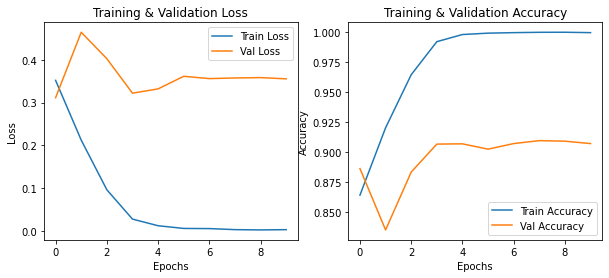

In [123]:
he_rmsprops = resnet18().to(device)
he_rmsprops.load_state_dict(torch.load("resnet_he_init_model.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(he_rmsprops.parameters(), lr=0.0001, alpha=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(he_rmsprops, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
loss_acc()
# torch.save(xe_sgd.state_dict(), "vgg16_xe_sgd_model.pth")

In [124]:
test_model(he_rmsprops, test_loader)

Test Loss: 0.3416, Test Accuracy: 0.9084


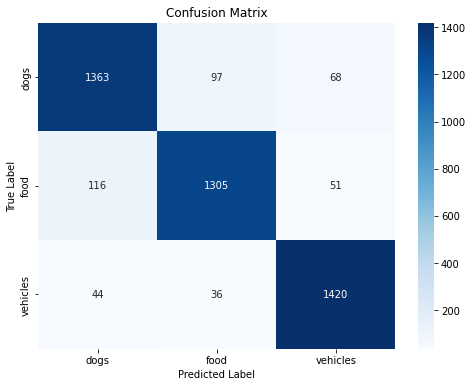

Precision: 0.9083
Recall: 0.9084
F1 Score: 0.9083


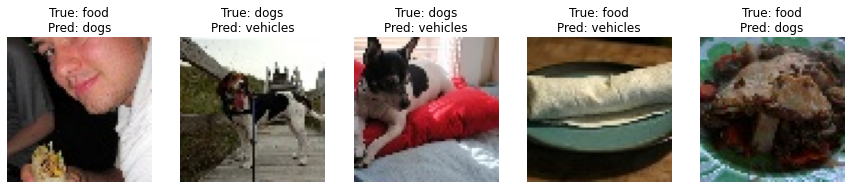

In [125]:
class_names = dataset.classes
plot_confusion_matrix(he_rmsprops, test_loader, class_names)
evaluate_metrics(he_rmsprops, test_loader)
show_misclassified_images(he_rmsprops, test_loader, class_names, num_images=5)

<h3>Xavier with adam is the best model,hence continuing further test with this configuration

In [126]:
test_model(xe_adam, test_loader)

Test Loss: 0.1405, Test Accuracy: 0.9482


In [127]:
torch.save(xe_adam.state_dict(), "resnet_xe_adam_model.pth")

<h3>Different Batch Size

100%|██████████| 657/657 [00:21<00:00, 30.87batch/s, loss=1.3, lr=0.0001]    


Epoch [1/10], Train Loss: 0.1064, Train Acc: 0.9606, Val Loss: 0.1497, Val Acc: 0.9462, Time: 24.5s


100%|██████████| 657/657 [00:20<00:00, 31.30batch/s, loss=0.873, lr=0.0001]  


Epoch [2/10], Train Loss: 0.1076, Train Acc: 0.9605, Val Loss: 0.1481, Val Acc: 0.9473, Time: 24.2s


100%|██████████| 657/657 [00:21<00:00, 31.18batch/s, loss=0.0205, lr=0.0001] 


Epoch [3/10], Train Loss: 0.1057, Train Acc: 0.9602, Val Loss: 0.1510, Val Acc: 0.9460, Time: 24.5s


100%|██████████| 657/657 [00:21<00:00, 30.96batch/s, loss=0.0404, lr=1e-5] 


Epoch [4/10], Train Loss: 0.1065, Train Acc: 0.9592, Val Loss: 0.1471, Val Acc: 0.9458, Time: 24.6s


100%|██████████| 657/657 [00:21<00:00, 31.29batch/s, loss=0.31, lr=1e-5]   


Epoch [5/10], Train Loss: 0.1085, Train Acc: 0.9594, Val Loss: 0.1491, Val Acc: 0.9484, Time: 24.3s


100%|██████████| 657/657 [00:20<00:00, 31.30batch/s, loss=0.149, lr=1e-5]  


Epoch [6/10], Train Loss: 0.1063, Train Acc: 0.9619, Val Loss: 0.1479, Val Acc: 0.9462, Time: 24.2s


100%|██████████| 657/657 [00:20<00:00, 31.41batch/s, loss=0.00165, lr=1e-6]


Epoch [7/10], Train Loss: 0.1084, Train Acc: 0.9602, Val Loss: 0.1489, Val Acc: 0.9456, Time: 24.4s


100%|██████████| 657/657 [00:21<00:00, 31.12batch/s, loss=0.326, lr=1e-6]  


Epoch [8/10], Train Loss: 0.1048, Train Acc: 0.9611, Val Loss: 0.1483, Val Acc: 0.9467, Time: 24.3s


100%|██████████| 657/657 [00:21<00:00, 30.34batch/s, loss=0.0499, lr=1e-6] 


Epoch [9/10], Train Loss: 0.1065, Train Acc: 0.9603, Val Loss: 0.1508, Val Acc: 0.9453, Time: 24.9s


100%|██████████| 657/657 [00:21<00:00, 30.75batch/s, loss=0.0559, lr=1e-7] 


Epoch [10/10], Train Loss: 0.1116, Train Acc: 0.9588, Val Loss: 0.1470, Val Acc: 0.9489, Time: 24.8s


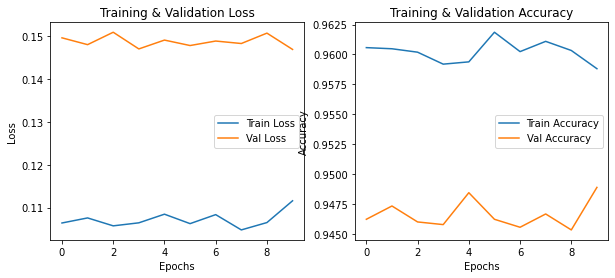

In [128]:
xe_adam_32 = resnet18().to(device)
xe_adam_32.load_state_dict(torch.load("resnet_xe_adam_model.pth", map_location=device))


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xe_adam_32.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_adam, train_loader32, val_loader32, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [129]:
test_model(xe_adam_32, test_loader32)

Test Loss: 0.1390, Test Accuracy: 0.9482


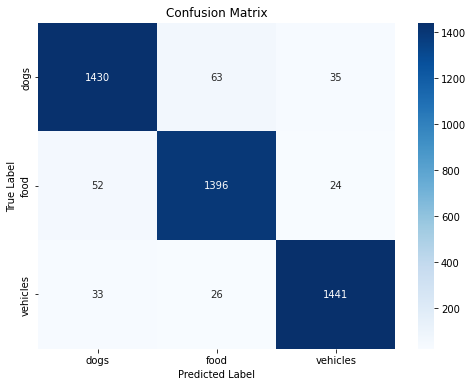

Precision: 0.9482
Recall: 0.9482
F1 Score: 0.9482


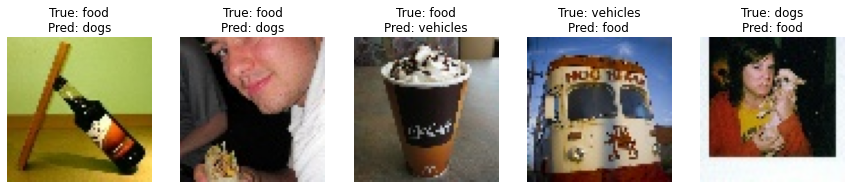

In [130]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam_32, test_loader32, class_names)
evaluate_metrics(xe_adam_32, test_loader32)
show_misclassified_images(xe_adam_32, test_loader32, class_names, num_images=5)

100%|██████████| 165/165 [00:12<00:00, 12.73batch/s, loss=0.0528, lr=0.0001]


Epoch [1/10], Train Loss: 0.0906, Train Acc: 0.9668, Val Loss: 0.1591, Val Acc: 0.9438, Time: 15.3s


100%|██████████| 165/165 [00:12<00:00, 13.02batch/s, loss=0.981, lr=0.0001] 


Epoch [2/10], Train Loss: 0.0858, Train Acc: 0.9706, Val Loss: 0.1937, Val Acc: 0.9324, Time: 14.9s


100%|██████████| 165/165 [00:12<00:00, 12.82batch/s, loss=0.365, lr=0.0001] 


Epoch [3/10], Train Loss: 0.0816, Train Acc: 0.9707, Val Loss: 0.1666, Val Acc: 0.9402, Time: 15.1s


100%|██████████| 165/165 [00:12<00:00, 12.92batch/s, loss=0.892, lr=1e-5] 


Epoch [4/10], Train Loss: 0.0536, Train Acc: 0.9843, Val Loss: 0.1614, Val Acc: 0.9478, Time: 15.1s


100%|██████████| 165/165 [00:13<00:00, 12.63batch/s, loss=0.0333, lr=1e-5]


Epoch [5/10], Train Loss: 0.0424, Train Acc: 0.9870, Val Loss: 0.1651, Val Acc: 0.9469, Time: 15.8s


100%|██████████| 165/165 [00:13<00:00, 12.55batch/s, loss=0.168, lr=1e-5]  


Epoch [6/10], Train Loss: 0.0396, Train Acc: 0.9880, Val Loss: 0.1624, Val Acc: 0.9500, Time: 15.5s


100%|██████████| 165/165 [00:12<00:00, 13.06batch/s, loss=0.0343, lr=1e-6]


Epoch [7/10], Train Loss: 0.0348, Train Acc: 0.9889, Val Loss: 0.1740, Val Acc: 0.9458, Time: 15.2s


100%|██████████| 165/165 [00:13<00:00, 12.47batch/s, loss=0.818, lr=1e-6]  


Epoch [8/10], Train Loss: 0.0403, Train Acc: 0.9886, Val Loss: 0.1683, Val Acc: 0.9469, Time: 15.8s


100%|██████████| 165/165 [00:12<00:00, 12.93batch/s, loss=0.036, lr=1e-6]  


Epoch [9/10], Train Loss: 0.0346, Train Acc: 0.9890, Val Loss: 0.1647, Val Acc: 0.9493, Time: 15.1s


100%|██████████| 165/165 [00:12<00:00, 13.02batch/s, loss=0.00304, lr=1e-7]


Epoch [10/10], Train Loss: 0.0348, Train Acc: 0.9892, Val Loss: 0.1695, Val Acc: 0.9489, Time: 15.0s


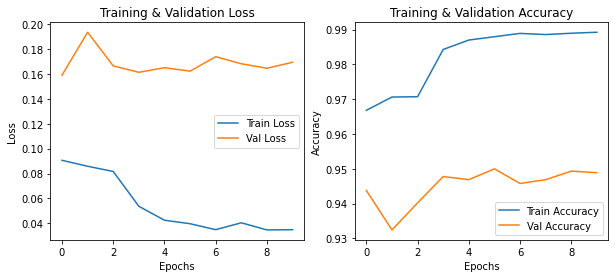

In [131]:
xe_adam_128 = resnet18().to(device)
xe_adam_128.load_state_dict(torch.load("resnet_xe_adam_model.pth", map_location=device))


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xe_adam_128.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_adam_128, train_loader128, val_loader128, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [132]:
test_model(xe_adam_128, test_loader128)

Test Loss: 0.1765, Test Accuracy: 0.9480


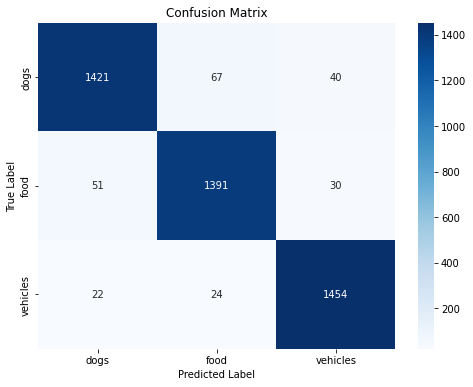

Precision: 0.9480
Recall: 0.9480
F1 Score: 0.9479


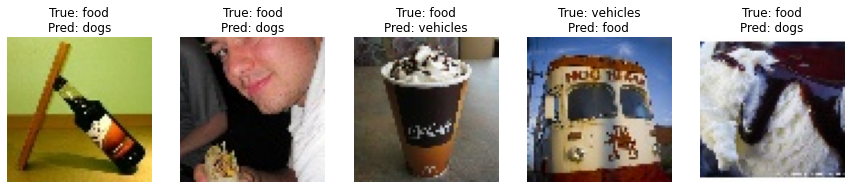

In [133]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam_128, test_loader128, class_names)
evaluate_metrics(xe_adam_128, test_loader128)
show_misclassified_images(xe_adam_128, test_loader128, class_names, num_images=5)

In [134]:
torch.save(xe_adam_32.state_dict(), "resnet_xe_adam_32_model.pth")


<h3>L2 Regularisation

100%|██████████| 657/657 [00:23<00:00, 27.53batch/s, loss=0.0135, lr=0.0001] 


Epoch [1/10], Train Loss: 0.1216, Train Acc: 0.9559, Val Loss: 0.1526, Val Acc: 0.9436, Time: 27.2s


100%|██████████| 657/657 [00:23<00:00, 27.50batch/s, loss=0.0124, lr=0.0001] 


Epoch [2/10], Train Loss: 0.1112, Train Acc: 0.9600, Val Loss: 0.1478, Val Acc: 0.9453, Time: 27.1s


100%|██████████| 657/657 [00:23<00:00, 27.77batch/s, loss=0.676, lr=0.0001]  


Epoch [3/10], Train Loss: 0.0973, Train Acc: 0.9648, Val Loss: 0.1664, Val Acc: 0.9422, Time: 26.9s


100%|██████████| 657/657 [00:23<00:00, 27.50batch/s, loss=0.0395, lr=1e-5] 


Epoch [4/10], Train Loss: 0.0556, Train Acc: 0.9809, Val Loss: 0.1638, Val Acc: 0.9462, Time: 27.3s


100%|██████████| 657/657 [00:23<00:00, 27.74batch/s, loss=0.364, lr=1e-5]  


Epoch [5/10], Train Loss: 0.0421, Train Acc: 0.9855, Val Loss: 0.1733, Val Acc: 0.9462, Time: 27.0s


100%|██████████| 657/657 [00:24<00:00, 27.26batch/s, loss=0.00427, lr=1e-5]


Epoch [6/10], Train Loss: 0.0357, Train Acc: 0.9882, Val Loss: 0.1795, Val Acc: 0.9462, Time: 27.4s


100%|██████████| 657/657 [00:23<00:00, 27.66batch/s, loss=0.00189, lr=1e-6] 


Epoch [7/10], Train Loss: 0.0270, Train Acc: 0.9922, Val Loss: 0.1755, Val Acc: 0.9458, Time: 27.1s


100%|██████████| 657/657 [00:23<00:00, 27.86batch/s, loss=0.527, lr=1e-6]   


Epoch [8/10], Train Loss: 0.0269, Train Acc: 0.9914, Val Loss: 0.1769, Val Acc: 0.9464, Time: 26.9s


100%|██████████| 657/657 [00:23<00:00, 27.38batch/s, loss=0.00632, lr=1e-6] 


Epoch [9/10], Train Loss: 0.0265, Train Acc: 0.9917, Val Loss: 0.1870, Val Acc: 0.9449, Time: 27.3s


100%|██████████| 657/657 [00:23<00:00, 27.48batch/s, loss=0.0147, lr=1e-7]  


Epoch [10/10], Train Loss: 0.0251, Train Acc: 0.9923, Val Loss: 0.1842, Val Acc: 0.9449, Time: 27.4s


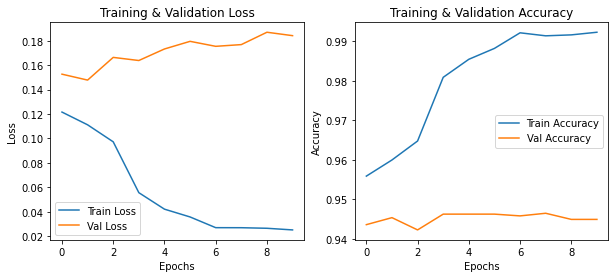

In [135]:
xe_adam_32_l2 = resnet18().to(device)
xe_adam_32_l2.load_state_dict(torch.load("resnet_xe_adam_32_model.pth", map_location=device))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    xe_adam_32_l2.parameters(),
    lr=0.0001,
    weight_decay=1e-4 
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 


num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(xe_adam_32_l2, train_loader32, val_loader32, criterion, optimizer, scheduler, num_epochs)
loss_acc()
#torch.save(xe_init_model.state_dict(), "vgg16_xe_init_model.pth")


In [136]:
test_model(xe_adam_32_l2, test_loader32)

Test Loss: 0.1799, Test Accuracy: 0.9471


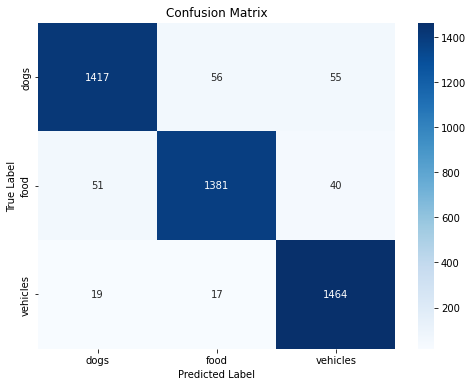

Precision: 0.9473
Recall: 0.9471
F1 Score: 0.9470


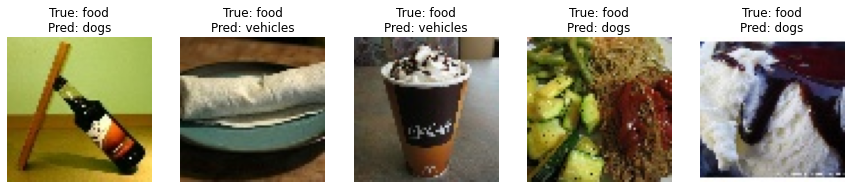

In [137]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam_32_l2, test_loader128, class_names)
evaluate_metrics(xe_adam_32_l2, test_loader128)
show_misclassified_images(xe_adam_32_l2, test_loader128, class_names, num_images=5)

<h3> Early Stopping

100%|██████████| 657/657 [00:24<00:00, 27.32batch/s, loss=0.0367, lr=0.0001]


Epoch [1/10], Train Loss: 0.1276, Train Acc: 0.9513, Val Loss: 0.1721, Val Acc: 0.9367, Time: 27.3s


100%|██████████| 657/657 [00:23<00:00, 27.67batch/s, loss=0.254, lr=0.0001]  


Epoch [2/10], Train Loss: 0.1119, Train Acc: 0.9576, Val Loss: 0.1633, Val Acc: 0.9413, Time: 26.9s


100%|██████████| 657/657 [00:23<00:00, 27.91batch/s, loss=0.344, lr=0.0001]  


Epoch [3/10], Train Loss: 0.0987, Train Acc: 0.9640, Val Loss: 0.1596, Val Acc: 0.9398, Time: 26.8s


100%|██████████| 657/657 [00:23<00:00, 27.44batch/s, loss=0.152, lr=1e-5]  


Epoch [4/10], Train Loss: 0.0567, Train Acc: 0.9810, Val Loss: 0.1526, Val Acc: 0.9471, Time: 27.2s


100%|██████████| 657/657 [00:24<00:00, 27.23batch/s, loss=0.738, lr=1e-5]   


Epoch [5/10], Train Loss: 0.0446, Train Acc: 0.9850, Val Loss: 0.1697, Val Acc: 0.9491, Time: 27.5s


100%|██████████| 657/657 [00:23<00:00, 27.70batch/s, loss=0.0645, lr=1e-5]  


Epoch [6/10], Train Loss: 0.0341, Train Acc: 0.9891, Val Loss: 0.1829, Val Acc: 0.9467, Time: 26.9s


100%|██████████| 657/657 [00:23<00:00, 27.65batch/s, loss=0.00385, lr=1e-6] 


Epoch [7/10], Train Loss: 0.0276, Train Acc: 0.9920, Val Loss: 0.1757, Val Acc: 0.9493, Time: 27.0s
Early stopping triggered!


ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

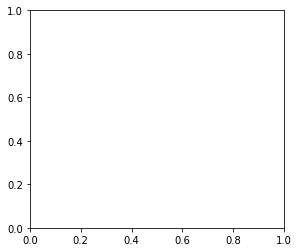

In [138]:

xe_adam_32_l2_es = resnet18().to(device)
xe_adam_32_l2_es.load_state_dict(torch.load("resnet_xe_adam_32_model.pth", map_location=device))



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    xe_adam_32_l2_es.parameters(),
    lr=0.0001,
    weight_decay=1e-4  
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 


num_epochs = 10

train_losses, val_losses, train_accs, val_accs = ES_train_model(xe_adam_32_l2_es, train_loader32, val_loader32, criterion, optimizer, scheduler, num_epochs)
loss_acc()



In [139]:
test_model(xe_adam_32_l2_es, test_loader32)

Test Loss: 0.1689, Test Accuracy: 0.9480


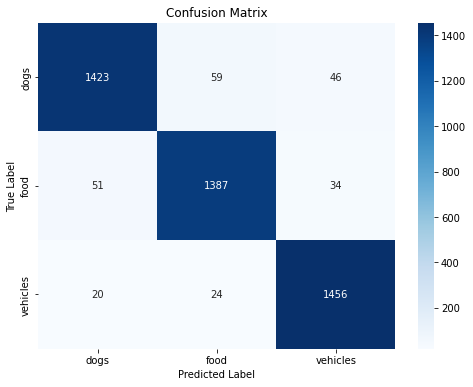

Precision: 0.9480
Recall: 0.9480
F1 Score: 0.9479


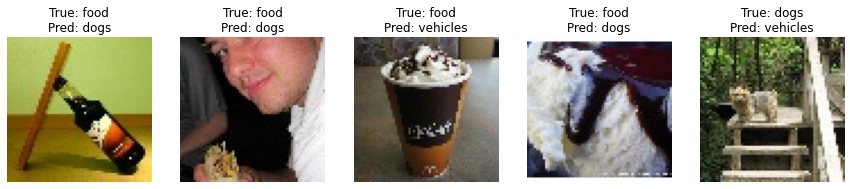

In [140]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam_32_l2_es, test_loader32, class_names)
evaluate_metrics(xe_adam_32_l2_es, test_loader32)
show_misclassified_images(xe_adam_32_l2_es, test_loader32, class_names, num_images=5)

<h3>Image augmentation

100%|██████████| 657/657 [00:27<00:00, 24.22batch/s, loss=0.188, lr=0.0001] 


Epoch [1/10], Train Loss: 0.1791, Train Acc: 0.9336, Val Loss: 0.1700, Val Acc: 0.9418, Time: 31.1s


100%|██████████| 657/657 [00:26<00:00, 24.53batch/s, loss=0.231, lr=0.0001] 


Epoch [2/10], Train Loss: 0.1648, Train Acc: 0.9375, Val Loss: 0.1475, Val Acc: 0.9464, Time: 30.8s


100%|██████████| 657/657 [00:26<00:00, 24.39batch/s, loss=0.155, lr=0.0001] 


Epoch [3/10], Train Loss: 0.1564, Train Acc: 0.9427, Val Loss: 0.1545, Val Acc: 0.9436, Time: 30.8s


100%|██████████| 657/657 [00:26<00:00, 24.39batch/s, loss=1.07, lr=1e-5]   


Epoch [4/10], Train Loss: 0.1300, Train Acc: 0.9528, Val Loss: 0.1383, Val Acc: 0.9513, Time: 30.9s


100%|██████████| 657/657 [00:27<00:00, 24.32batch/s, loss=0.0108, lr=1e-5] 


Epoch [5/10], Train Loss: 0.1200, Train Acc: 0.9553, Val Loss: 0.1381, Val Acc: 0.9480, Time: 30.9s


100%|██████████| 657/657 [00:27<00:00, 24.17batch/s, loss=0.32, lr=1e-5]  


Epoch [6/10], Train Loss: 0.1216, Train Acc: 0.9547, Val Loss: 0.1285, Val Acc: 0.9544, Time: 31.2s


100%|██████████| 657/657 [00:27<00:00, 24.32batch/s, loss=0.0347, lr=1e-6] 


Epoch [7/10], Train Loss: 0.1156, Train Acc: 0.9586, Val Loss: 0.1298, Val Acc: 0.9564, Time: 30.9s


100%|██████████| 657/657 [00:26<00:00, 24.36batch/s, loss=1.04, lr=1e-6]   


Epoch [8/10], Train Loss: 0.1107, Train Acc: 0.9607, Val Loss: 0.1362, Val Acc: 0.9507, Time: 30.9s


100%|██████████| 657/657 [00:26<00:00, 24.42batch/s, loss=0.015, lr=1e-6]  


Epoch [9/10], Train Loss: 0.1152, Train Acc: 0.9591, Val Loss: 0.1295, Val Acc: 0.9533, Time: 30.9s


100%|██████████| 657/657 [00:26<00:00, 24.44batch/s, loss=0.122, lr=1e-7] 


Epoch [10/10], Train Loss: 0.1112, Train Acc: 0.9594, Val Loss: 0.1258, Val Acc: 0.9571, Time: 30.8s


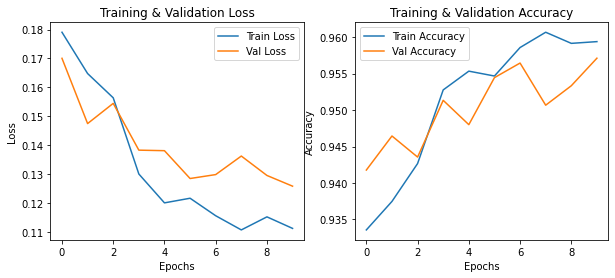

In [141]:
xe_adam_32_data = resnet18().to(device)
xe_adam_32_data.load_state_dict(torch.load("resnet_xe_adam_32_model.pth", map_location=device))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    xe_adam_32_data.parameters(),
    lr=0.0001,
    weight_decay=1e-4  
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 


num_epochs = 10

train_losses, val_losses, train_accs, val_accs = train_model(xe_adam_32_data, train_loader32_aug, val_loader32_aug, criterion, optimizer, scheduler, num_epochs)
loss_acc()

In [142]:
test_model(xe_adam_32_data,test_loader32_aug)

Test Loss: 0.1245, Test Accuracy: 0.9562


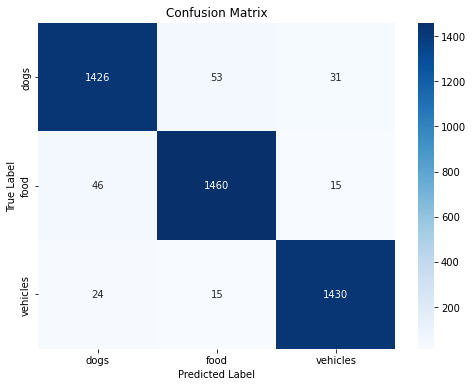

Precision: 0.9580
Recall: 0.9580
F1 Score: 0.9580


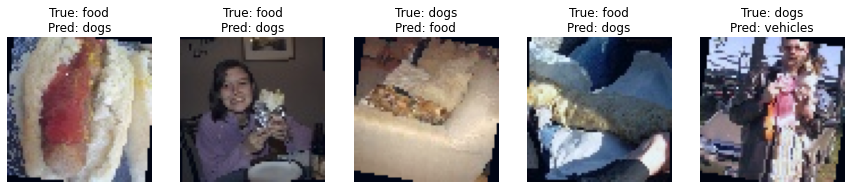

In [143]:
class_names = dataset.classes
plot_confusion_matrix(xe_adam_32_data, test_loader32_aug, class_names)
evaluate_metrics(xe_adam_32_data, test_loader32_aug)
show_misclassified_images(xe_adam_32_data, test_loader32_aug, class_names, num_images=5)

<h3>Tensorboard output

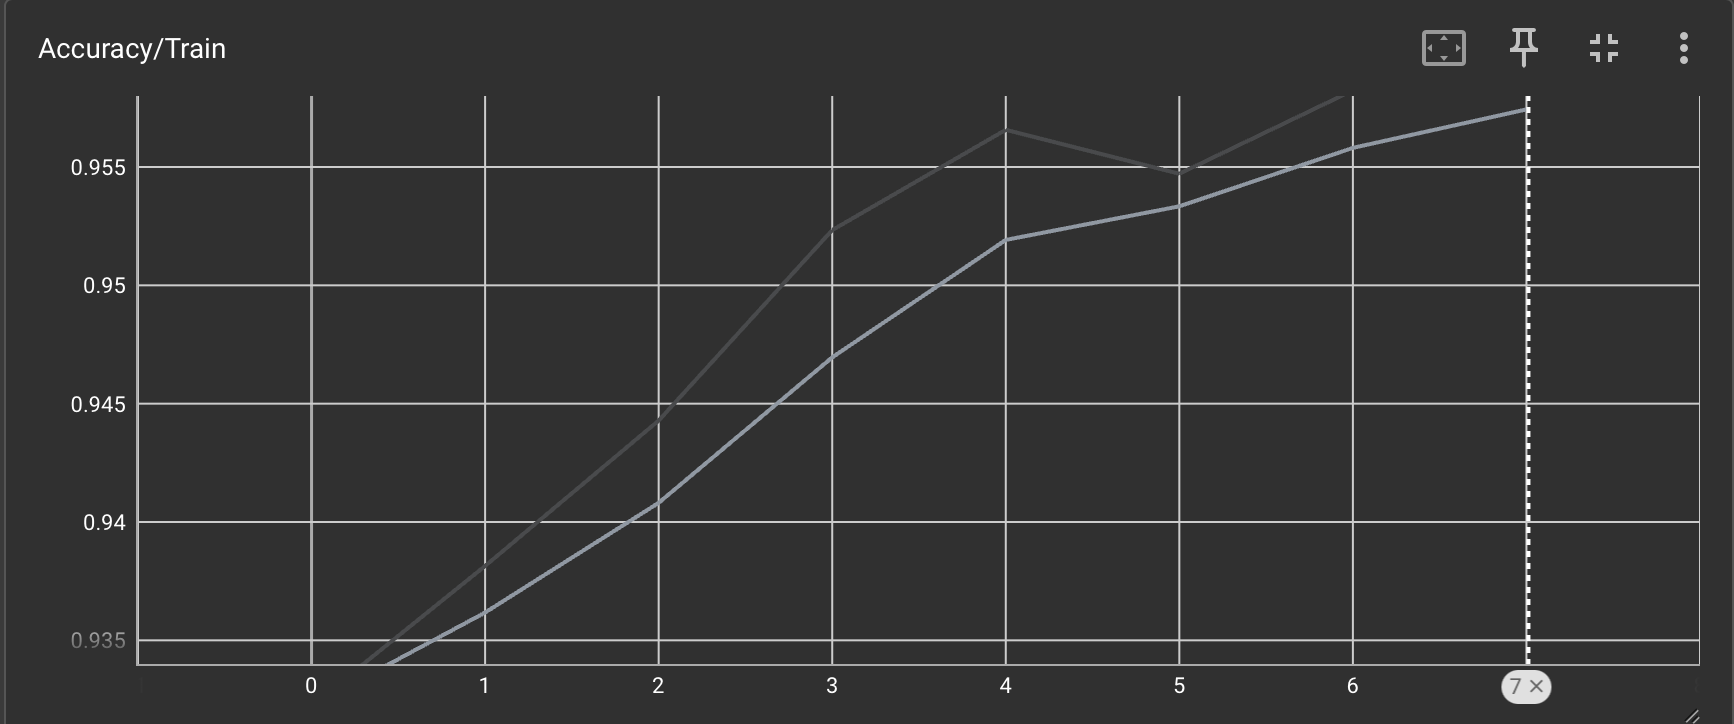

Training Accuracy over Epooch

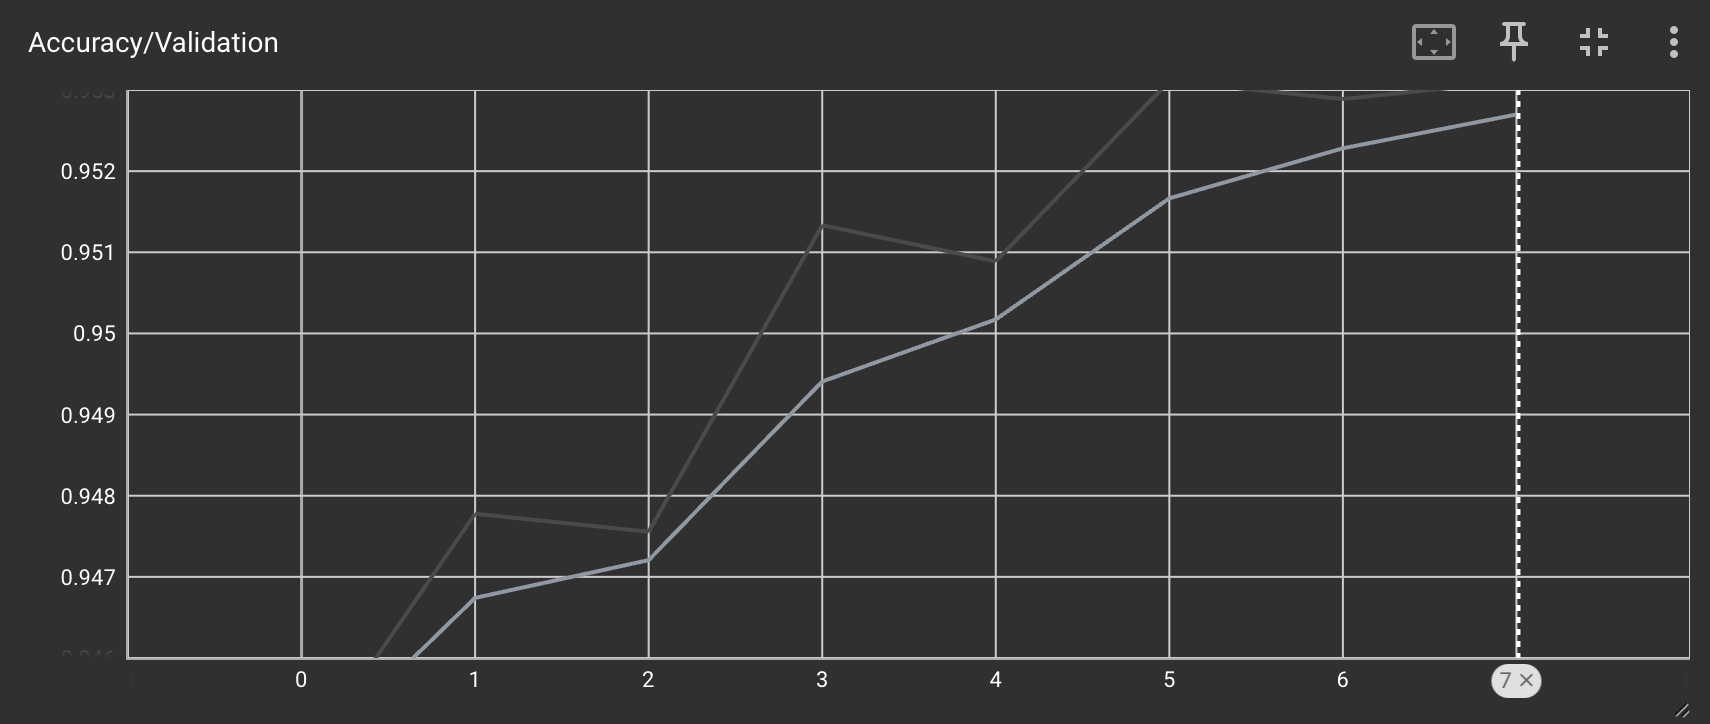

Validation Accuracy over Epooch


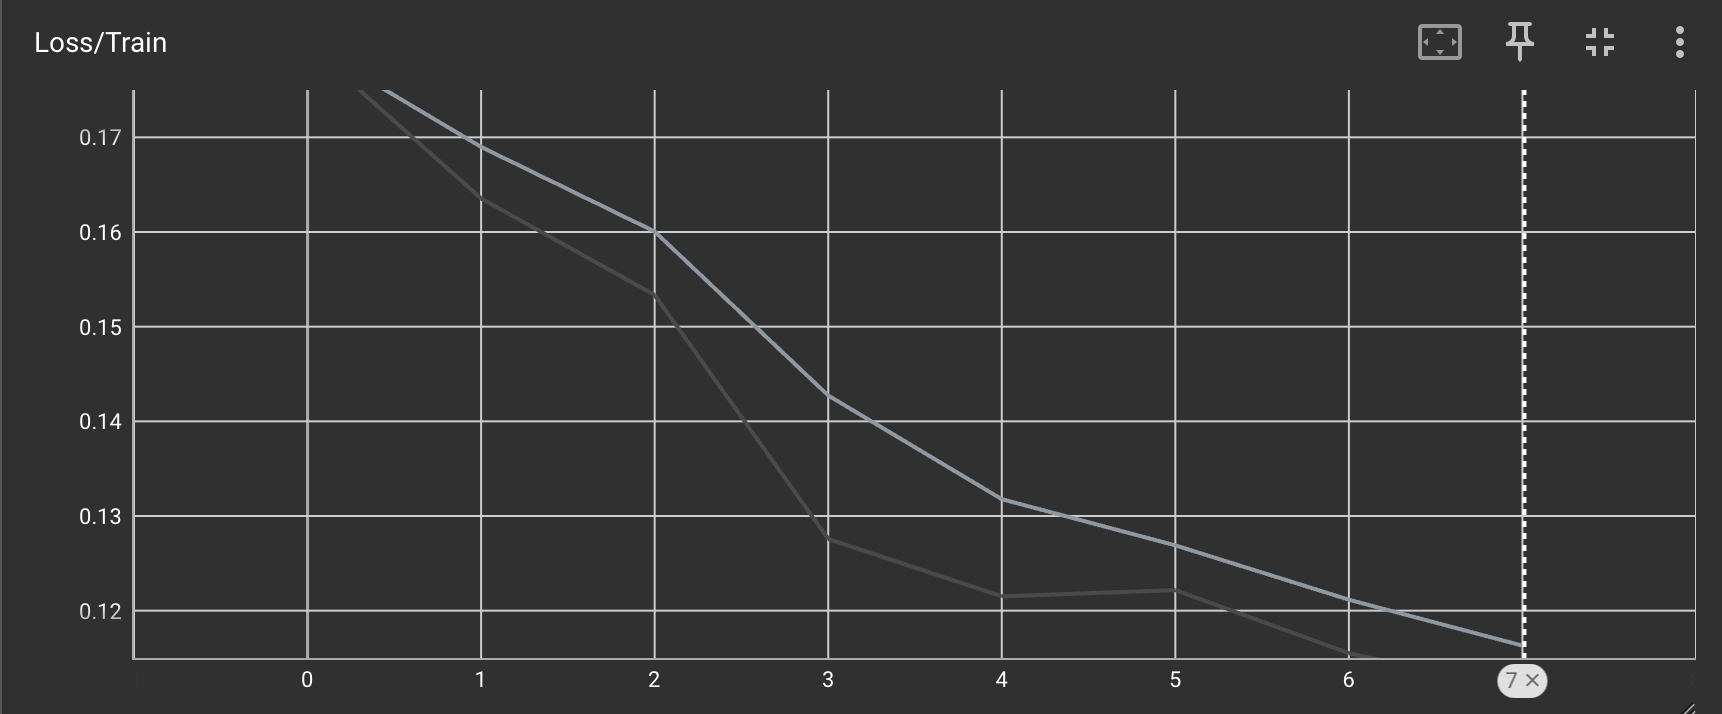

Training loss over Epooch

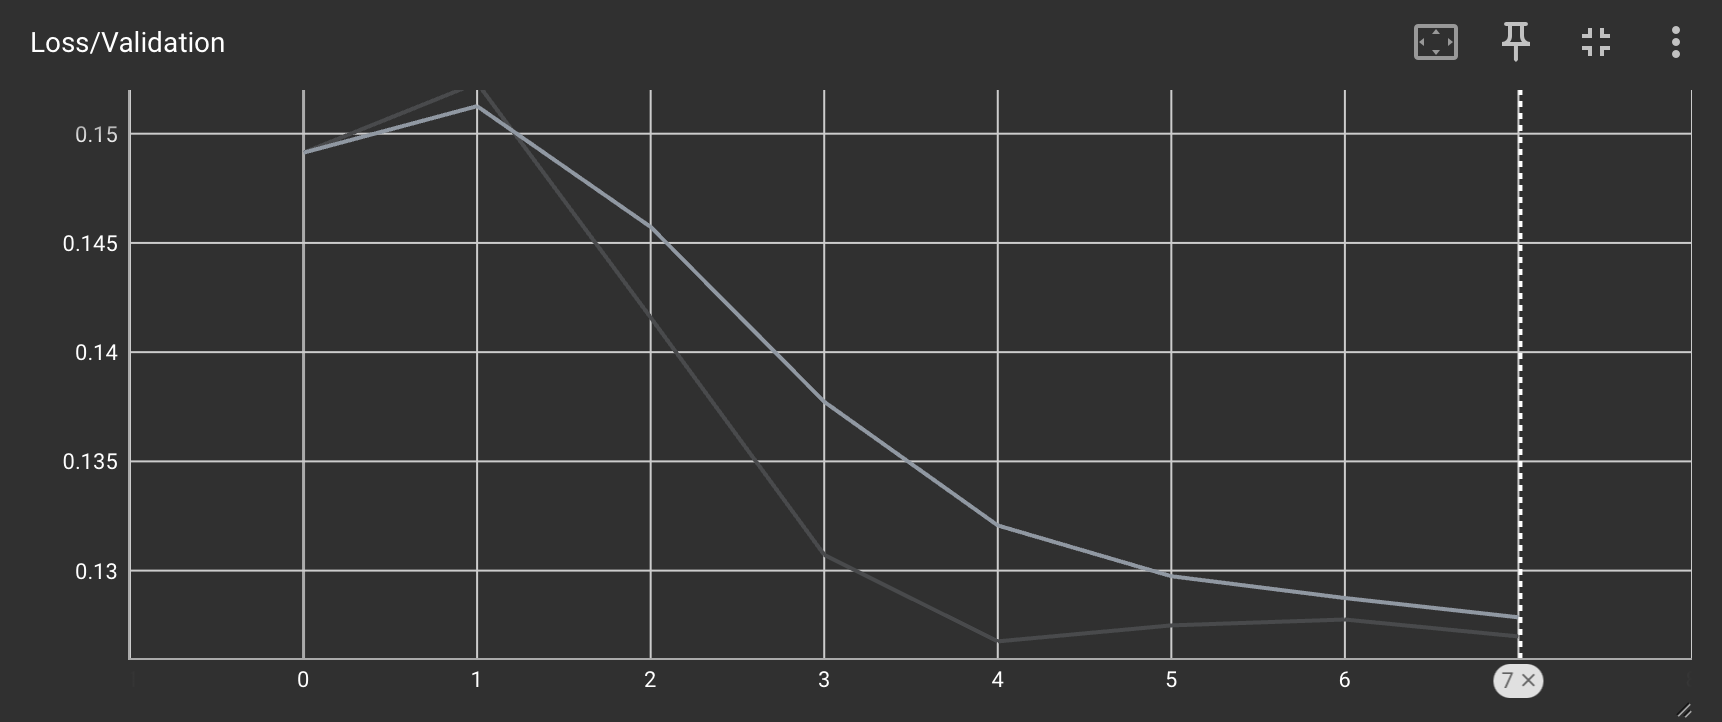
Validation loss over Epooch

In [147]:
torch.save(xe_adam_32_data.state_dict(), "resnet_best_model.pth")


In [144]:
best2 =train_losses, val_losses, train_accs, val_accs 

In [149]:
import json


VGG = {
    "train_losses": best[0],
    "val_losses": best[1],
    "train_accs": best[2],
    "val_accs":best[3]
}

with open("VGG.json", "w") as f:
    json.dump(VGG, f)


In [151]:


ResNet = {
    "train_losses": best2[0],
    "val_losses": best2[1],
    "train_accs": best2[2],
    "val_accs":best2[3]
}

with open("ResNet.json", "w") as f:
    json.dump(ResNet, f)


## Step 4: Discussion and conclusion

<h3>1. Explain the theoretical concepts behind VGG and ResNet.

VGG-C and ResNet-18 are both deep learning models used for image recognition, but they work in very different ways. VGG-C is a version of the VGG model, which simply stacks many smallfilters on top of each other. This makes it easy to understand and good at detecting patterns, but as the network gets deeper, it becomes slow and struggles with the vanishing gradient problem, meaning the deeper layers don’t learn properly. 

ResNet-18, on the other hand, is a smarter design with 18 layers and special skip connections that let information jump over some layers instead of passing through all of them. This makes training much easier and helps the model avoid losing accuracy as it gets deeper. While VGG-C just keeps adding more layers in a straight line, ResNet-18 uses these shortcuts to learn better and faster. 

<h3> 2. Discuss the impact of regularization and optimization techniques.

Image Augmentation: This technique artificially increases the training dataset by applying transformations like rotation, flipping, cropping, and color shifts to images. This helps the model generalize better by learning from varied inputs, reducing overfitting, and improving robustness to real-world variations

Early Stopping: This is a simple regularization method that stops training when the model's validation performance starts to degrade or doesn't improve , preventing overfitting. It ensures that the model does not learn patterns specific to the training data but instead generalizes well to unseen data

Different Batch Sizes : The choice of batch size affects both training stability and performance. Smaller batch sizes can introduce more noise but improve generalization, while larger batch sizes provide more stable gradient updates but may lead to poorer generalization

L2 Regularization : L2 regularization helps prevent overfitting by adding a small penalty to large weights in the model. This encourages smaller, more stable weight values, making the network more robust and preventing it from memorizing noise in the data.

<h3>3.Analysis

When comparing VGG-16 and ResNet-18 using F1 score, precision, recall, training loss, validation loss, and accuracy over epochs, ResNet-18 performs better overall. It has higher F1 scores, precision, and recall, meaning it makes more accurate predictions. Looking at loss curves, ResNet-18 keeps the loss lower and more stable, showing that it learns efficiently. In terms of accuracy, ResNet-18 improves faster and reaches higher accuracy because of its skip connections, which help the model learn better


<h3>4. Summarize your findings and discuss the advantages of residual connections.

Residual connections in ResNet let information skip some layers, making deep networks easier to train. This prevents the vanishing gradient problem, helping the model learn faster and perform better. Because of this, ResNet can be much deeper than VGG while still working efficiently.

<h3>Observation

The model weights stored for ResNet is smaller in size compared to the weight store for VGG model

<h3>5. References.

1. https://scikit-learn.org/

2. https://arxiv.org/pdf/1409.1556

3. https://pytorch.org/docs/stable/index.html

4. https://arxiv.org/pdf/1512.03385